### 2012 Election Trends

Data and inspiration were taken from this Kaggle dataset.
https://www.kaggle.com/joelwilson/2012-2016-presidential-elections

My goal is to determine which features drove the county level wins for Barack Obama in 2012. Secondarily, I'll explore the 2004 and 2012 elections.

Quick Primer on US Elections.

Presidents are elected by 

1) Getting more than 270 Electoral votes AND
2) Getting more votes than their opponent.

At least in modern times, a candidate has never gotten more than the required 270 and lost. I won't go into the procedure for candidates getting less than 270 votes.

From: https://www.archives.gov/federal-register/electoral-college/about.html

How are electoral votes allocated? 
"Electoral votes are allocated among the states based on the Census. Every state is allocated a number of votes equal to the number of senators and representatives in its U.S. Congressional delegation—two votes for its senators in the U.S. Senate plus a number of votes equal to the number of its members in the U. S. House of Representatives.

What is the difference between the winner-takes-all rule and proportional voting, and which states follow which rule?

The District of Columbia and 48 states have a winner-takes-all rule for the Electoral College. In these States, whichever candidate receives a majority of the popular vote, or a plurality of the popular vote (less than 50 percent but more than any other candidate), takes all of the state’s Electoral votes.

Only two states, Nebraska and Maine, do not follow the winner-takes-all rule. In those states, there could be a split of Electoral votes among candidates through the state’s system for proportional allocation of votes."

Fun Fact: The electoral college is part of the constitution, therefore states can switch from winner-take-all to proportional voting, but any chants of "Abolish the Electoral College!" would need to accompany a new amendment, which needs two-thirds of the House and Senate to approve, then it's sent to the states for a vote. Three-fourths of the states must vote to approve it. As some people say: "America. Love it or Leave it!"

We're working with county level data and the goal is to try to predict county level results. County wins are meaningless in elections, but predicting elections with state level data would leave us with a very small dataset and tell us almost nothing about what demographics correlate with electoral wins.







#### Things to add later on.

- Refactor some of the graphing code. Too much copy/paste
- Re-run RFE without previous election data to find best features
- Display Feature importances in a more visually appealing way
- Add things that will add to the model (News stories. Stock Prices. Employment. Polling Data. Etc)
- 2004 model. 2008 model. 2012 Model. Compare drivers.
- Clean up imports.
- Explore 50/50 counties in more detail for vote percentage.
- Updated Slides
- Make regplots and linear models to augment exploratory analysis
- Output list of 

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#import graphing packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#import modeling packages
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

#import feature and hyperparameter tuning packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

#import stats packages
from scipy import stats
from scipy.stats import uniform
from sklearn import metrics

#import scoring packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# load county facts and dropn na's
county = pd.read_csv('county_facts.csv').dropna()
# load 2004/2008/2012 results data and drop redundant or useless columns
votes_04_12 = pd.read_csv('04_12.csv').dropna()
votes_04_12.drop(['county'], axis=1, inplace = True)



In [2]:
county.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
5,1007,Bibb County,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,0.0,0.0,0,0,124707,5804,10757,19,622.58,36.8
6,1009,Blount County,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,0.0,23.2,341544,0,319700,5622,20941,3,644.78,88.9


In [3]:
votes_04_12.head()

,year,state,fips,vote_rep,vote_dem,vote_oth,vote_total,pct_rep,pct_dem,pct_oth,winner,runnerup,pct_winner,margin_winner_over_runnerup
0,2004,AL,01001,15196,4758,127,20081,75.7,23.7,0.6,rep,dem,75.7,52.0
1,2004,AL,01003,52971,15599,750,69320,76.4,22.5,1.1,rep,dem,76.4,53.9
2,2004,AL,01005,5899,4832,46,10777,54.7,44.8,0.4,rep,dem,54.7,9.9
3,2004,AL,01007,5472,2089,39,7600,72.0,27.5,0.5,rep,dem,72.0,44.5
4,2004,AL,01009,17386,3938,180,21504,80.9,18.3,0.8,rep,dem,80.9,62.6


In [4]:
county.describe()

,fips,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
count,3143.000000,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,...,3143.000000,3143.000000,3.143000e+03,3.143000e+03,3.143000e+03,3143.000000,3.143000e+03,3143.000000,3143.000000,3143.000000
mean,30390.411709,1.014499e+05,9.823675e+04,0.465670,9.823275e+04,5.895291,22.539325,17.570379,49.901782,85.051384,...,1.690232,17.950652,1.419672e+06,1.210827e+06,1.245402e+06,10236.157175,1.929055e+05,332.714922,1123.737515,259.322431
std,15164.717720,3.261273e+05,3.129130e+05,4.190895,3.129012e+05,1.218243,3.436701,4.450029,2.440961,16.323134,...,6.225769,12.852328,5.705414e+06,7.297393e+06,4.136397e+06,5434.069482,8.848278e+05,1297.106512,3611.418200,1724.159773
min,1001.000000,0.000000e+00,0.000000e+00,-17.000000,8.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,2.000000,0.000000
25%,18178.000000,1.102550e+04,1.110450e+04,-2.000000,1.110450e+04,5.200000,20.500000,14.800000,49.500000,80.300000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,7.597950e+04,6852.500000,6.063000e+03,5.000000,430.725000,16.900000
50%,29177.000000,2.571300e+04,2.585700e+04,-0.200000,2.585700e+04,5.800000,22.500000,17.300000,50.400000,92.000000,...,0.000000,23.200000,0.000000e+00,4.422100e+04,2.471360e+05,9728.000000,2.508000e+04,32.000000,615.630000,45.200000
75%,45082.000000,6.773950e+04,6.670000e+04,2.200000,6.669900e+04,6.500000,24.200000,19.900000,51.100000,96.000000,...,0.000000,27.800000,8.962050e+05,2.491225e+05,7.662475e+05,12934.000000,9.305100e+04,146.000000,923.955000,113.850000
max,56045.000000,1.011670e+07,9.818664e+06,72.900000,9.818605e+06,13.700000,42.000000,52.900000,56.800000,99.300000,...,78.000000,56.200000,1.692751e+08,2.054788e+08,1.191118e+08,80800.000000,2.485784e+07,40060.000000,145504.790000,69467.500000


None of the maxes or mins look out of line here.

The fips code for the three datasets is formatted differently, we'll be joining on fips later, so let's make these all the same.

In [5]:
#covnert fips codes to strings
county['fips'] = county['fips'].astype(str)

     
#add a zero in front of county data fips codes that are 4 digits long
for index, row in county.iterrows():
     if len(row['fips']) == 4:
             county['fips'][index] = ('0' + row['fips'])
          
            
            

In [6]:
county.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
2,01001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,01003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,01005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
5,01007,Bibb County,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,0.0,0.0,0,0,124707,5804,10757,19,622.58,36.8
6,01009,Blount County,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,0.0,23.2,341544,0,319700,5622,20941,3,644.78,88.9


Alaska changed their county and fips data over the years, so it's going to cause us some problems when we merge, so we'll just drop Alaska from our analysis.

In [7]:
votes_04_12 = votes_04_12[votes_04_12.state != 'AK']
county = county[county.state_abbreviation != 'AK']


First, lets clean up the column names from the three datasets, then we'll merge then on the fips column.

In [8]:
county.columns

Index(['fips', 'area_name', 'state_abbreviation', 'PST045214', 'PST040210',
       'PST120214', 'POP010210', 'AGE135214', 'AGE295214', 'AGE775214',
       'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214', 'RHI425214',
       'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214', 'POP715213',
       'POP645213', 'POP815213', 'EDU635213', 'EDU685213', 'VET605213',
       'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213', 'HSG495213',
       'HSD410213', 'HSD310213', 'INC910213', 'INC110213', 'PVY020213',
       'BZA010213', 'BZA110213', 'BZA115213', 'NES010213', 'SBO001207',
       'SBO315207', 'SBO115207', 'SBO215207', 'SBO515207', 'SBO415207',
       'SBO015207', 'MAN450207', 'WTN220207', 'RTN130207', 'RTN131207',
       'AFN120207', 'BPS030214', 'LND110210', 'POP060210'],
      dtype='object')

In [9]:
county = county.rename(columns={
                   'PST045214':'population_2014',
                   'PST040210':'population_2010_estimated',
                   'AGE135214': 'under_5',
                   'AGE295214': 'under_18',
                   'age65plus': 'over_65',
                   'SEX255214': 'female',
                   'RHI325214': 'american_indian',
                   'RHI425214': 'asian',
                   'RHI525214': 'pacific_islander',
                   'RHI625214': 'two_plus_races',
                   'POP715213': 'same_home_one_year_plus',
                   'POP645213': 'foreign_born',
                   'LFE305213': 'commute_time',
                   'HSG010214':'housing_units',
                   'HSG445213': 'home_ownership',
                   'HSG096213':'multi_unit_housing',
                   'HSG495213':'median_home_value',
                   'HSD410213': 'households',
                   'HSD310213':'person_per_household',
                   'INC110213': 'median_income',
                   'Poverty': 'poverty',
                   'BZA010213': 'private_establishments',
                   'BZA110213':'private_nonfarm_employemnt',
                   'BZA115213' : 'non_farm_employment_change',
                   'NES010213': 'non_employer_establishments',
                   'SBO001207': 'total_firms',
                   'SBO315207': 'black_firms',
                   'SBO115207': 'american_indian_firms',
                   'SBO215207': 'asian_firms',
                   'SBO515207': 'pacific_islander_firms',
                   'SBO415207': 'hispanic_firms',
                   'SBO015207': 'female_firms',
                   'MAN450207': 'manufacturing_shipments',
                   'WTN220207': 'wholesaling_sales',
                   'RTN130207': 'retail_sales',
                   'RTN131207': 'retail_sales_per_cap',
                   'AFN120207': 'hotel_food_sales',
                   'BPS030214': 'building_permits',
                   'LND110210': 'land_area_sqmiles',
                   'VET605213':'veterans',
                   'RHI725214':'hispanic',
                   'POP815213': 'bilingual',
                   'EDU635213': 'hs_diploma_per',
                   'EDU685213': 'bachelors_per',
                   'PST120214': 'pop_per_change', 
                   'POP010210': 'population_2010',
                   'AGE775214': 'over_65', 
                   'RHI125214': 'white', 
                   'RHI225214': 'black',
                   'INC910213': 'per_capita_income',
                   'PVY020213': 'poverty_per', 
                   'POP060210': 'pop_per_sm',
                   'RHI825214': 'white_alone_non_hisp',
                   'state_abbreviation': 'state',
                    'area_name' : 'county'
})
                   
                   
                   
                   

In [10]:
county.columns

Index(['fips', 'county', 'state', 'population_2014',
       'population_2010_estimated', 'pop_per_change', 'population_2010',
       'under_5', 'under_18', 'over_65', 'female', 'white', 'black',
       'american_indian', 'asian', 'pacific_islander', 'two_plus_races',
       'hispanic', 'white_alone_non_hisp', 'same_home_one_year_plus',
       'foreign_born', 'bilingual', 'hs_diploma_per', 'bachelors_per',
       'veterans', 'commute_time', 'housing_units', 'home_ownership',
       'multi_unit_housing', 'median_home_value', 'households',
       'person_per_household', 'per_capita_income', 'median_income',
       'poverty_per', 'private_establishments', 'private_nonfarm_employemnt',
       'non_farm_employment_change', 'non_employer_establishments',
       'total_firms', 'black_firms', 'american_indian_firms', 'asian_firms',
       'pacific_islander_firms', 'hispanic_firms', 'female_firms',
       'manufacturing_shipments', 'wholesaling_sales', 'retail_sales',
       'retail_sales_per_ca

In [11]:
len(county.columns)

54

We're going to split our 04/08/12 data in seperate dataframes to be able to train and test on them later, we'll also recombine them as a wide dataset.

In [12]:
votes_04_12.columns

Index(['year', 'state', 'fips', 'vote_rep', 'vote_dem', 'vote_oth',
       'vote_total', 'pct_rep', 'pct_dem', 'pct_oth', 'winner', 'runnerup',
       'pct_winner', 'margin_winner_over_runnerup'],
      dtype='object')

In [13]:
#split data into each year of voting
votes_04 = votes_04_12[votes_04_12.year == 2004]
votes_08 = votes_04_12[votes_04_12.year == 2008]
votes_12 = votes_04_12[votes_04_12.year == 2012]


Let's make sure the votes are actually close to the results.

In [14]:
print('Year Republican Democrat Margin')
print('2004', votes_04['vote_rep'].sum(), votes_04['vote_dem'].sum(),votes_04['vote_rep'].sum()-votes_04['vote_dem'].sum())
print('2008', votes_08['vote_rep'].sum(), votes_08['vote_dem'].sum(), votes_08['vote_rep'].sum()-votes_08['vote_dem'].sum()) 
print('2012', votes_12['vote_rep'].sum(), votes_12['vote_dem'].sum(), votes_12['vote_rep'].sum()-votes_12['vote_dem'].sum() )



Year Republican Democrat Margin
2004 61839222 58909973 2929249
2008 59765336 69423801 -9658465
2012 60756719 65765676 -5008957


These are all off just slightly from a few of the sources on the web, but election results seem to vary slightly based on the source and the official data sits behind paywalls. They're all close enough to be considered accurate for our goal here.

Next, we'll rename the columns to include the year.

In [15]:
votes_04 = votes_04.rename(columns={'vote_rep': 'vote_rep_04',
                   'vote_dem':'vote_dem_04',
                    'vote_oth':'vote_oth_04',
                   'vote_total': 'vote_total_04',
                   'per_dem': 'per_dem_04',
                   'vote_total': 'total_votes_04',
                   'pct_rep': 'pct_rep_04',
                   'pct_dem': 'pct_dem_04',
                    'pct_oth':'pct_oth_04',
                    'winner':'winner_04',
                    'runnerup':'runnerup_04',
                    'pct_winner': 'pct_winner_04',
                    'margin_winner_over_runnerup':'margin_04'})

votes_08 = votes_08.rename(columns={'vote_rep': 'vote_rep_08',
                   'vote_dem':'vote_dem_08',
                    'vote_oth':'vote_oth_08',
                   'vote_total': 'vote_total_08',
                   'per_dem': 'per_dem_08',
                   'vote_total': 'total_votes_08',
                   'pct_rep': 'pct_rep_08',
                   'pct_dem': 'pct_dem_08',
                    'pct_oth':'pct_oth_08',
                    'winner':'winner_08',
                    'runnerup':'runnerup_08',
                    'pct_winner': 'pct_winner_08',
                     'margin_winner_over_runnerup':'margin_08'})

votes_12 = votes_12.rename(columns={'vote_rep': 'vote_rep_12',
                   'vote_dem':'vote_dem_12',
                    'vote_oth':'vote_oth_12',
                   'vote_total': 'vote_total_12',
                   'per_dem': 'per_dem_12',
                   'vote_total': 'total_votes_12',
                   'pct_rep': 'pct_rep_12',
                   'pct_dem': 'pct_dem_12',
                    'pct_oth':'pct_oth_12',
                    'winner':'winner_12',
                    'runnerup':'runnerup_12',
                    'pct_winner': 'pct_winner_12',
                     'margin_winner_over_runnerup':'margin_12'})

In [16]:
print(len(votes_04), len(votes_08), len(votes_12), len(county))


3114 3114 3113 3114


In [17]:
#drop redundant data
votes_04.drop(['year', 'state'], axis=1, inplace = True)
votes_08.drop(['year', 'state'], axis=1, inplace = True)
votes_12.drop(['year', 'state'], axis=1, inplace = True)

It looks like a county got dropped in 2012. We'll inspect it after the merge. Also, I went ahead and dropped year and state. It will be redundant.

In [18]:
from functools import reduce
data_frames  = [county, votes_04, votes_08, votes_12]
election_full = reduce(lambda left,right: pd.merge(left,right,on=['fips'],
                                            how='outer'), data_frames)
    
election_04 = county.merge(votes_04, on='fips', how = 'outer')
election_08 = county.merge(votes_08, on='fips', how = 'outer')
election_12 = county.merge(votes_12, on='fips', how = 'outer')

election_full['turnout_12'] = election_full['total_votes_12']/election_full['population_2010']
election_full['turnout_08'] = election_full['total_votes_08']/election_full['population_2010']
election_full['turnout_04'] = election_full['total_votes_04']/election_full['population_2010']


In [19]:
print(len(election_full))
print(election_full.isnull().sum().sum())
print(election_04.winner_04.isnull().sum().sum())
print(election_08.winner_08.isnull().sum().sum())
print(election_12.winner_12.isnull().sum().sum())


3114
12
0
0
1


11 missing data points, but they're probably all from the same county. Let's just make sure this one county that possibly no longer exists isn't going to cause problems. Turns out it's a tiny county in Hawaii. 

In [20]:
election_12[election_12.vote_rep_12.isnull()]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,vote_dem_12,vote_oth_12,total_votes_12,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12
519,15005,Kalawao County,HI,89,90,-1.1,90,0.0,0.0,29.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
election_12[election_12.vote_rep_12.isnull()]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,vote_dem_12,vote_oth_12,total_votes_12,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12
519,15005,Kalawao County,HI,89,90,-1.1,90,0.0,0.0,29.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
election_full.head()

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
0,01001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,72.49,26.54,0.96,rep,dem,72.49,45.95,0.439299,0.433215,0.367979
1,01003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,77.39,21.57,1.04,rep,dem,77.39,55.82,0.466288,0.446674,0.380325
2,01005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,48.19,51.33,0.48,dem,rep,51.33,3.14,0.419456,0.423571,0.392505
3,01007,Bibb County,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,72.83,26.15,1.02,rep,dem,72.83,46.68,0.367445,0.377220,0.331660
4,01009,Blount County,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,86.27,12.34,1.38,rep,dem,86.27,73.93,0.419734,0.423345,0.375144


In [23]:
#drop row with missing data
election_full.dropna(inplace = True)
election_12.dropna(inplace = True)


Ok. It looks like we finally have a merged and cleaned dataset. Let's start exploring our data. But first, let's add a voter turnout column, then we'll see how the counties voted. Although we're going to train and test on 04/08 data and leave out the 2012 data for testing only, we'll still include the 2012 data in the exploratory analysis.

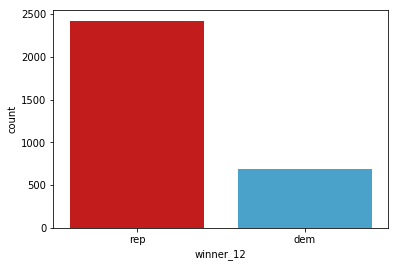

In [24]:
sns.countplot(x= 'winner_12',  data = election_full, palette=["#DE0100", "#34AAE0"])

2004 election
 rep    2527
dem     586
Name: winner_04, dtype: int64
2008 election
 rep    2237
dem     876
Name: winner_08, dtype: int64
2012 election
 rep    2422
dem     691
Name: winner_12, dtype: int64


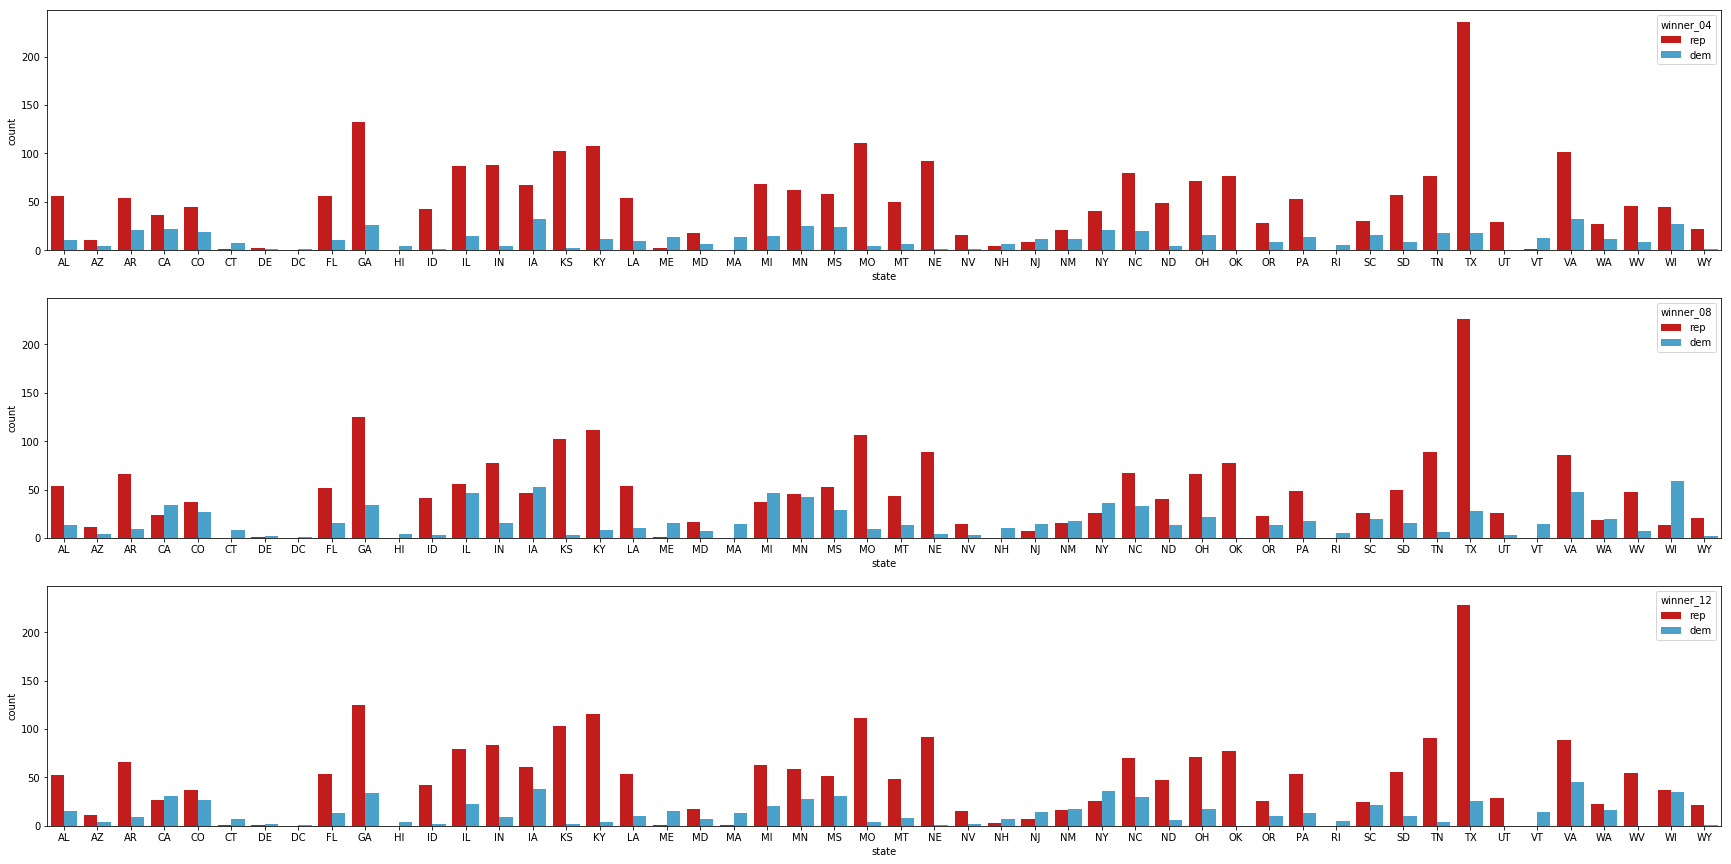

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows= 3, sharey=True, figsize=(30,15))
sns.countplot(x= 'state', hue= 'winner_04',   data = election_full, palette=["#DE0100", "#34AAE0"], ax = ax1) # yes I did up the hex codes 
sns.countplot(x= 'state', hue ='winner_08',  data = election_full, palette=["#DE0100", "#34AAE0"], ax = ax2)
sns.countplot(x= 'state', hue ='winner_12',  data = election_full, palette=["#DE0100", "#34AAE0"], ax = ax3)                               
print('2004 election\n', election_full.winner_04.value_counts())
print('2008 election\n', election_full.winner_08.value_counts())
print('2012 election\n', election_full.winner_12.value_counts())

#use other graphs for presentation

count     50.000000
mean      62.260000
std       47.058283
min        1.000000
25%       23.250000
50%       63.000000
75%       87.750000
max      254.000000
dtype: float64


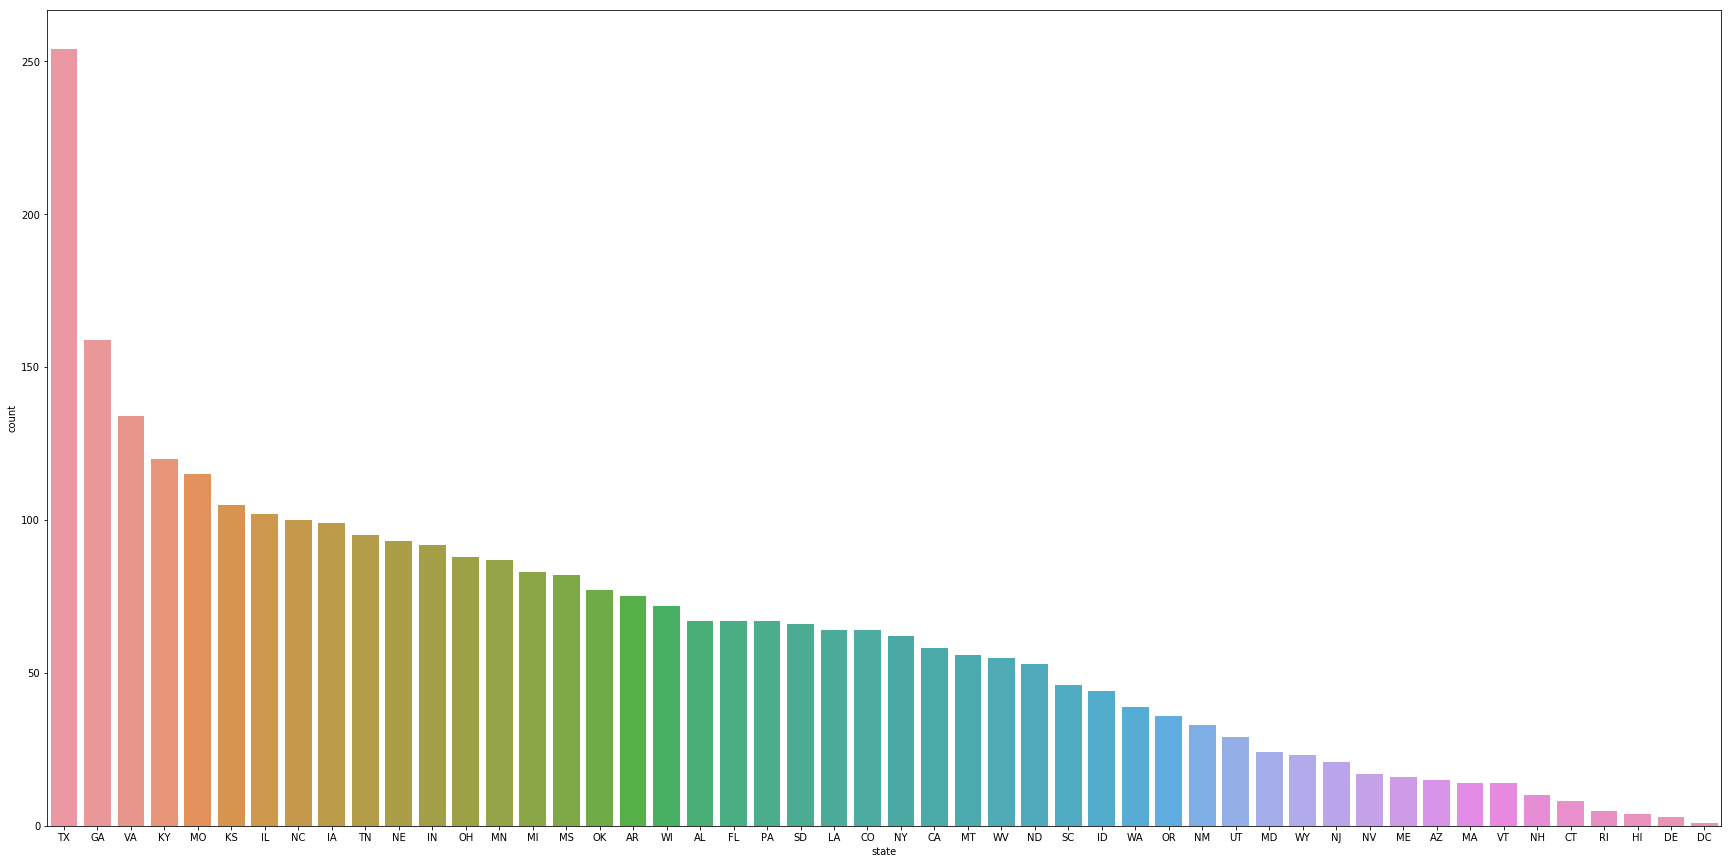

In [26]:
county_counts = election_full.groupby(['state']).size()
print(county_counts.describe())

fig, ax1 = plt.subplots(ncols=1 ,figsize=(30,15))
sns.countplot(x= 'state', data = election_full, order = election_full['state'].value_counts().index, ax = ax1)

plt.show()


This doesn't look like much at first, but there are some noteable datapoints here. 

First, we notice that Republicans, even in landslide electoral losses(08-12), tend to win far more counties than Democrats.

Counties aren't evenly distributed by state, and traditional Republican states seem to have far more counties than Democratic states. We can also see this state area size/population doesn't seem to correlate well with # of counties. Texas has the most counties, which we might expect, but California, the largest state, only, has 58 counties which is less than the average of 62. The # of counties seems to have a distinct Mid-West bias. 5 of the top 10 states with the most counties are in the mid-west. We have to go all the way down to 27th to get to what's considered a western state (Colorado - 64 counties).  

To summarize: We have a large class imbalance. 

For the non-political or the non-U.S. readers, a simple hueristic for National Elections is that Rebuplicans dominate in rural areas where Democrats dominate in urban areas. Suburban-ish areas are fluid based on demographics. This is why Obama's win in 2008 was such a blowout by modern standards, he appealed to people in a variety of counties/areas. 

Also noteable are the large gains Obama made at the county level from the 04-08 election. He won more counties than he lost in states where the opposite was true for Democrats in 2004: Iowa, California, Michigan, New York, Wisconsin, and came close in Minnesota. Democrats won all of these states in 2004, except for Iowa, although the vote margin in Iowa was only 10,000 votes in 04. Again, this shows Obama's broad appeal in his (modern-day) landslide 2008 win. 


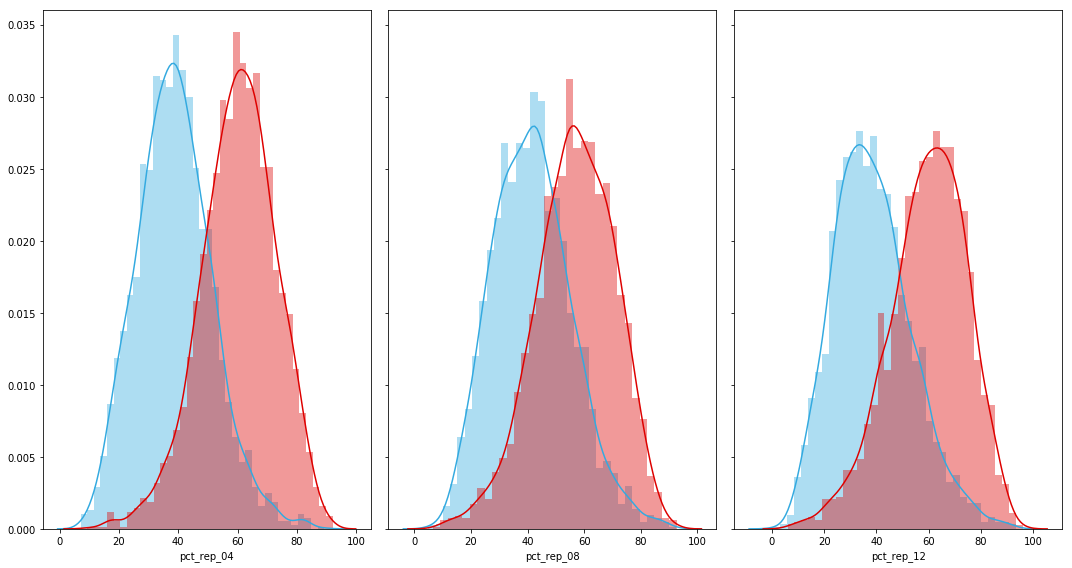

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey=True, figsize=(15,8))
sns.distplot( election_full["pct_dem_04"] , color="#34AAE0", ax=ax1)
sns.distplot( election_full["pct_rep_04"] , color="#DE0100", ax=ax1)
sns.distplot( election_full["pct_dem_08"] , color="#34AAE0",ax=ax2 )
sns.distplot( election_full["pct_rep_08"] , color="#DE0100",ax=ax2 )
sns.distplot( election_full["pct_dem_12"] , color="#34AAE0",ax=ax3)
sns.distplot( election_full["pct_rep_12"] , color="#DE0100",ax=ax3 )

plt.tight_layout()
plt.show()
#for presentation, you should use the bigger single graphs.

This is interesting. You would maybe expect the 2004 election to have been the biggest win by popular vote, but the 2004 election was actually the closest of the 3. What I tink we're seeing is that Obama's broad appeal increased the Democratic vote count in so many counties that more counties become closely contested. Even though it wasn't enough to flip the county, the votes added up to state-level wins. 

In [28]:
years = ['winner_04', 'winner_08', 'winner_12']
labels = ['2004', '2008', '2012']
for year, label in zip(years,labels):
    print("-"*40, label, "-"*40)
    print("Black", election_full.groupby(year).black.describe())
    print("White", election_full.groupby(year).white_alone_non_hisp.describe())
    print("Asian", election_full.groupby(year).asian.describe())
    print("Hispanic", election_full.groupby(year).hispanic.describe())
    print("Two races", election_full.groupby(year).two_plus_races.describe())
    



---------------------------------------- 2004 ----------------------------------------
Black             count       mean        std  min  25%   50%    75%   max
winner_04                                                           
dem         586.0  18.116041  22.866065  0.1  1.0  5.35  31.55  85.1
rep        2527.0   7.252473  10.726323  0.0  0.7  2.10   8.45  57.4
White             count       mean        std  min     25%    50%     75%   max
winner_04                                                                
dem         586.0  63.991638  26.801497  3.1  41.025  68.75  89.875  98.0
rep        2527.0  80.437080  16.114331  0.0  70.450  86.20  93.500  98.6
Asian             count      mean       std  min  25%  50%  75%   max
winner_04                                                      
dem         586.0  2.675427  4.778929  0.0  0.5  0.9  2.8  42.4
rep        2527.0  1.055046  1.490231  0.0  0.4  0.6  1.1  19.6
Hispanic             count       mean        std  min  25%  50%   7

A quick note on how to read this: These are the percentage of residents of a certain race, by county, grouped by counties that Republicans or Democrats won. It SHOULD be read as "Among 2012 counties that democrats won, the average percentage of black residents was 20%". It shuold NOT be read as "Among 2012 counties that demoracts won, 20% of black voters went for Democrats". In fact, these numbers don't say anything about votes OR voters at all. It's just the demographics of the counties. We don't know who voted, or whom they voted for.

We get pretty much what we expected: Democrats win more racially/ethnically diverse counties; Republicans win less racially/ethnically diverse counties. We do get some great outliers we'll look into -- I'm staring at you, 59% black county that went Republican in 2008.  

The 2008 election was delightfully counterintuitive; The average percentage of Black residents in counties that Democrats won is lower than in 2004 or 2012. Why? Becuase Obama won ~300 more counties than Kerry did in 2004. America is majority white, so winning more counties meant more majority white counties flipped to the Democrats, which made the average 2008 Democratic winning county more White.

The concentration of Black residents as opposed to Hispanic/Asian residents also jumps out. African-Americans make up roughly 12% of the population, Asian-Americans 5%, Hispanics (of any race) 17%, but there seem to be many more counties with higher concentrations of Black residents than Asian or Hispanic residents. 




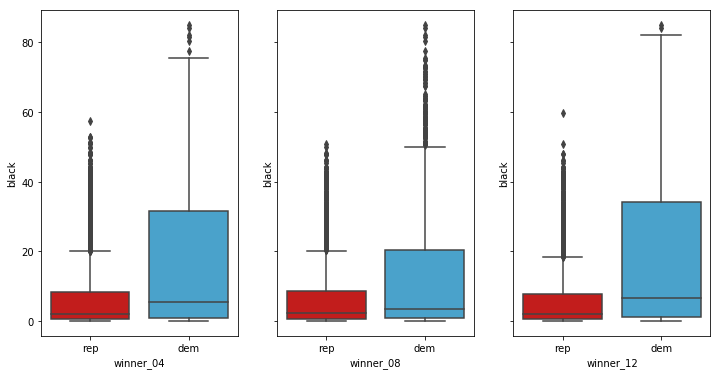

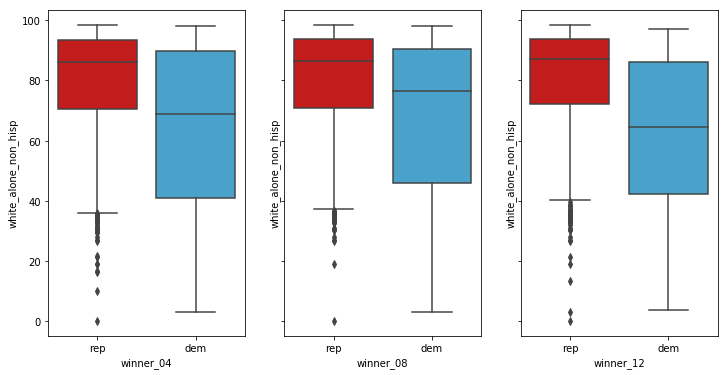

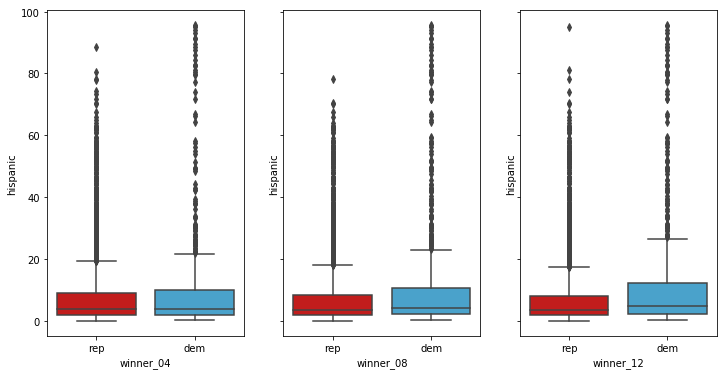

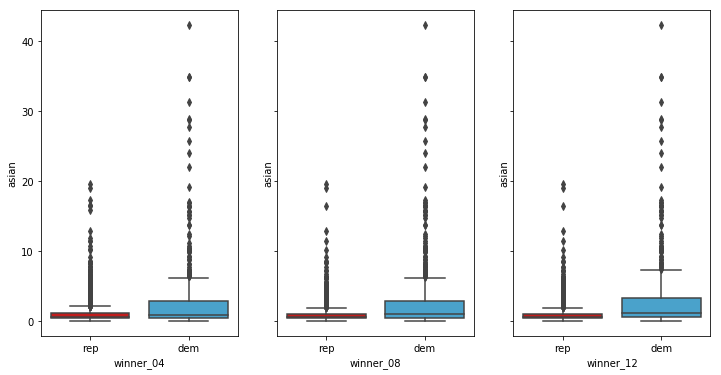

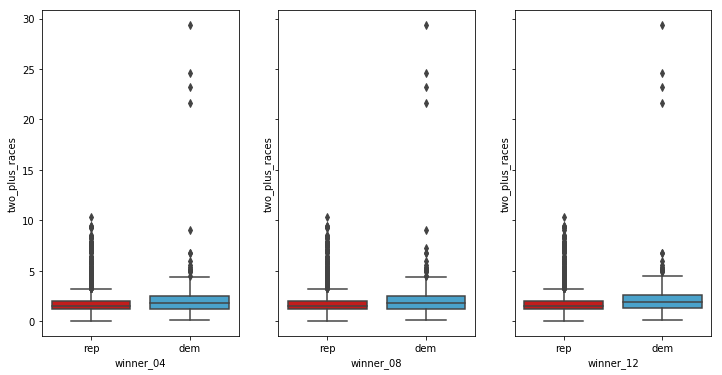

In [29]:
demographic = ['black', 'white_alone_non_hisp', 'hispanic', 'asian', 'two_plus_races']
my_pal = {"rep": "#DE0100", "dem": "#34AAE0"}

for col in demographic:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey=True, figsize=(12,6))
    sns.boxplot(x = "winner_04",  y=col, data=election_full, palette=my_pal ,ax=ax1, showfliers = True)
    sns.boxplot( x = "winner_08",  y=col, data=election_full, palette=my_pal, ax=ax2, showfliers = True)
    sns.boxplot(x = "winner_12",  y=col, data=election_full, palette=my_pal, ax = ax3 , showfliers = True)

    plt.show()



This isn't too surprising. Whites make up the largest % of the population and have among the highest turnout rates among racial groups. What does jump out is that purely from a racial/ethnic standpoint, the 2012 election looked almost identical to the 2004 election. (Reminder for non-U.S. audience, '04: Bush-Kerry, '08:Obama-McCain, '12: Obama-Romney).

Now lets take a look at a few of those outliers.

In [30]:
election_full[(election_full['black'] > 50) & (election_full['winner_04'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
45,01091,Marengo County,AL,20110,21029,-4.4,21027,6.0,23.0,18.6,...,46.23,53.43,0.35,dem,rep,53.43,7.20,0.548961,0.545537,0.490893
479,13247,Rockdale County,GA,87754,85215,3.0,85215,6.0,25.6,12.8,...,41.28,57.85,0.87,dem,rep,57.85,16.57,0.446741,0.442481,0.365910
486,13261,Sumter County,GA,31232,32817,-4.8,32819,6.5,24.0,14.8,...,45.46,53.88,0.66,dem,rep,53.88,8.42,0.360492,0.372802,0.344039
507,13303,Washington County,GA,20635,21187,-2.6,21187,6.1,22.3,16.0,...,45.82,53.53,0.66,dem,rep,53.53,7.71,0.415679,0.418323,0.370369
1097,22027,Claiborne Parish,LA,16412,17195,-4.6,17195,5.3,18.4,17.5,...,54.20,44.77,1.02,rep,dem,54.20,9.43,0.391509,0.397848,0.385577
1386,28029,Copiah County,MS,28797,29449,-2.2,29449,6.4,23.6,15.4,...,44.48,54.87,0.65,dem,rep,54.87,10.39,0.479575,0.492445,0.386702
1428,28113,Pike County,MS,40058,40407,-0.9,40404,7.0,26.6,15.6,...,45.52,53.69,0.80,dem,rep,53.69,8.17,0.444857,0.446862,0.411642
1453,28163,Yazoo County,MS,27817,28065,-0.9,28065,6.7,24.2,12.4,...,42.52,56.82,0.65,dem,rep,56.82,14.30,0.414039,0.408944,0.391484


In [31]:
election_full[(election_full['black'] > 50) & (election_full['winner_08'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
1097,22027,Claiborne Parish,LA,16412,17195,-4.6,17195,5.3,18.4,17.5,...,54.2,44.77,1.02,rep,dem,54.2,9.43,0.391509,0.397848,0.385577


In [32]:
election_full[(election_full['black'] > 50) & (election_full['winner_12'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
453,13193,Macon County,GA,13792,14740,-6.4,14740,4.9,19.9,14.9,...,54.67,44.54,0.79,rep,dem,54.67,10.13,0.215061,0.337924,0.324084
1097,22027,Claiborne Parish,LA,16412,17195,-4.6,17195,5.3,18.4,17.5,...,54.20,44.77,1.02,rep,dem,54.20,9.43,0.391509,0.397848,0.385577


Claiborne Parish is the only majority Black county that went Red in 2004 and stayed Red through 2012. Macon County Georgia actually went Blue in 2012, this is just a reporting error in the data. We'll drop this county.

In [33]:
election_full.drop(election_full.index[453], inplace = True)

In [34]:
election_full[(election_full['white_alone_non_hisp'] < 5) & (election_full['winner_04'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2887,51515,Bedford city,VA,0,0,0.0,6222,0.0,0.0,0.0,...,54.44,43.67,1.89,rep,dem,54.44,10.77,0.45082,0.439409,0.40855


In [35]:
election_full[(election_full['white_alone_non_hisp'] < 5) & (election_full['winner_08'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2887,51515,Bedford city,VA,0,0,0.0,6222,0.0,0.0,0.0,...,54.44,43.67,1.89,rep,dem,54.44,10.77,0.45082,0.439409,0.40855


In [36]:
election_full[(election_full['white_alone_non_hisp'] < 5) & (election_full['winner_12'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2655,48323,Maverick County,TX,57023,54258,5.1,54258,9.0,31.9,11.4,...,85.69,13.32,0.99,rep,dem,85.69,72.37,0.009271,0.201611,0.184931
2887,51515,Bedford city,VA,0,0,0.0,6222,0.0,0.0,0.0,...,54.44,43.67,1.89,rep,dem,54.44,10.77,0.450820,0.439409,0.408550


Bedford City County has some issues with it's 2014 population, but it's votes and winner check out okay using another source. We'll address the population issue later.

In [37]:
election_full[(election_full['hispanic'] > 75) & (election_full['winner_04'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2524,48061,Cameron County,TX,420392,406220,3.5,406220,8.7,31.6,12.4,...,33.94,64.99,1.07,dem,rep,64.99,31.05,0.189294,0.186246,0.170243
2575,48163,Frio County,TX,18531,17217,7.6,17217,7.0,24.4,11.6,...,39.29,59.88,0.83,dem,rep,59.88,20.59,0.230470,0.235930,0.228263
2608,48229,Hudspeth County,TX,3211,3476,-7.6,3476,6.4,24.5,17.2,...,54.58,43.92,1.51,rep,dem,54.58,10.66,0.248274,0.258343,0.254891
2726,48465,Val Verde County,TX,48974,48879,0.2,48879,8.3,28.9,13.8,...,46.64,52.02,1.33,dem,rep,52.02,5.38,0.247161,0.262280,0.241310


In [38]:
election_full[(election_full['hispanic'] > 75) & (election_full['winner_08'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2608,48229,Hudspeth County,TX,3211,3476,-7.6,3476,6.4,24.5,17.2,...,54.58,43.92,1.51,rep,dem,54.58,10.66,0.248274,0.258343,0.254891


In [39]:
election_full[(election_full['hispanic'] > 95) & (election_full['winner_12'] == 'rep')]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,...,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2655,48323,Maverick County,TX,57023,54258,5.1,54258,9.0,31.9,11.4,...,85.69,13.32,0.99,rep,dem,85.69,72.37,0.009271,0.201611,0.184931


In [40]:
pd.options.display.max_columns = None
election_full[election_full['county'] == 'Maverick County']

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,female,white,black,american_indian,asian,pacific_islander,two_plus_races,hispanic,white_alone_non_hisp,same_home_one_year_plus,foreign_born,bilingual,hs_diploma_per,bachelors_per,veterans,commute_time,housing_units,home_ownership,multi_unit_housing,median_home_value,households,person_per_household,per_capita_income,median_income,poverty_per,private_establishments,private_nonfarm_employemnt,non_farm_employment_change,non_employer_establishments,total_firms,black_firms,american_indian_firms,asian_firms,pacific_islander_firms,hispanic_firms,female_firms,manufacturing_shipments,wholesaling_sales,retail_sales,retail_sales_per_cap,hotel_food_sales,building_permits,land_area_sqmiles,pop_per_sm,vote_rep_04,vote_dem_04,vote_oth_04,total_votes_04,pct_rep_04,pct_dem_04,pct_oth_04,winner_04,runnerup_04,pct_winner_04,margin_04,vote_rep_08,vote_dem_08,vote_oth_08,total_votes_08,pct_rep_08,pct_dem_08,pct_oth_08,winner_08,runnerup_08,pct_winner_08,margin_08,vote_rep_12,vote_dem_12,vote_oth_12,total_votes_12,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
2655,48323,Maverick County,TX,57023,54258,5.1,54258,9.0,31.9,11.4,50.6,96.9,0.6,1.5,0.5,0.0,0.4,95.1,3.1,89.2,34.9,94.2,56.6,12.2,1159,20.3,18034,71.1,15.7,86300,15714,3.45,13668,31395,30.5,771,11360,-0.3,4427,4417,0.0,0.0,0.0,0.0,78.0,0.0,0,0,504755,9897,48530,99,1279.26,42.4,4025,5948,61,10034,40.1,59.3,0.6,dem,rep,59.3,19.2,2316,8554,69,10939,21.17,78.2,0.63,dem,rep,78.2,57.03,431.0,67.0,5.0,503.0,85.69,13.32,0.99,rep,dem,85.69,72.37,0.009271,0.201611,0.184931


It turns out Maverick county is not as Maverick-y as its name implies, this just an error in the data. Maverick county went 70% Democrat in the 2012 election. As I mentioned above there seem to be some minor reporting incosistencies in the publicly available election data. We'll strike this county from the dataset. 

Note: I'm cross checking the results against https://uselectionatlas.org/RESULTS/, which seems to be very accurate. County level data is only available for $60 and the site doesn't make scraping the data possible.

In [41]:
election_full.drop(election_full.index[2655], inplace = True)

In [42]:
election_full.shape

(3111, 90)

As we saw, sometimes counties don't vote the way we expect them to go, and candidates that can broaden the appeal of the party can drastically influence what the average red or blue county looks like.

Let's move on to Population/Gender/Class/Education, etc.

In [43]:
election_features = election_full.drop(['vote_rep_04','vote_dem_04','vote_oth_04','total_votes_04','pct_rep_04',
                                       'pct_dem_04','pct_oth_04','runnerup_04','pct_winner_04','vote_rep_08',
                                       'vote_dem_08','vote_oth_08','total_votes_08','pct_rep_08',
                                       'pct_dem_08','pct_oth_08','runnerup_08','pct_winner_08','vote_rep_12',
                                       'vote_dem_12','vote_oth_12','total_votes_12','pct_rep_12','pct_dem_12',
                                       'pct_oth_12','runnerup_12','pct_winner_12'],axis = 1)


In [44]:
years = ['winner_04', 'winner_08', 'winner_12']
labels = ['2004', '2008', '2012']
for year, label in zip(years,labels):
    print("-"*40, label, "-"*40)
    print("High School grad", election_full.groupby(year).hs_diploma_per.describe())
    print("Female", election_full.groupby(year).female.describe())
    print("Age Over 65", election_full.groupby(year).over_65.describe())
    print("College Grad", election_full.groupby(year).bachelors_per.describe())
    print("Income", election_full.groupby(year).median_income.describe())
    print("poverty_per", election_full.groupby(year).poverty_per.describe())
    print("population_2010", election_full.groupby(year).population_2010.describe())

---------------------------------------- 2004 ----------------------------------------
High School grad             count       mean       std   min   25%   50%   75%   max
winner_04                                                           
dem         585.0  84.068547  8.477749  45.0  78.2  87.0  90.5  97.3
rep        2526.0  84.626762  6.486451  54.0  80.4  85.8  89.5  99.0
Female             count       mean       std   min   25%   50%   75%   max
winner_04                                                           
dem         585.0  50.362222  2.167180  36.1  49.8  50.7  51.5  55.0
rep        2526.0  49.843428  2.415926   0.0  49.4  50.3  50.9  56.8
Age Over 65             count       mean       std  min   25%   50%   75%   max
winner_04                                                          
dem         585.0  16.294701  3.924552  6.7  13.6  16.1  18.9  31.8
rep        2526.0  17.940974  4.438428  0.0  15.1  17.6  20.3  52.9
College Grad             count       mean        std 

Things we might expect:
- Democratic counties are usually more female, younger, and have higer levels of education. 

Things we didn't expect:
- The percentage of high school grads is fairly even, but Democratic counties have a wider variance of hs grads.   
- Democratic counties have higher rates of poverty, Republican counties have lower median incomes.

Comparing year over year, this data is no fun at all. We'll illustrate that below. 

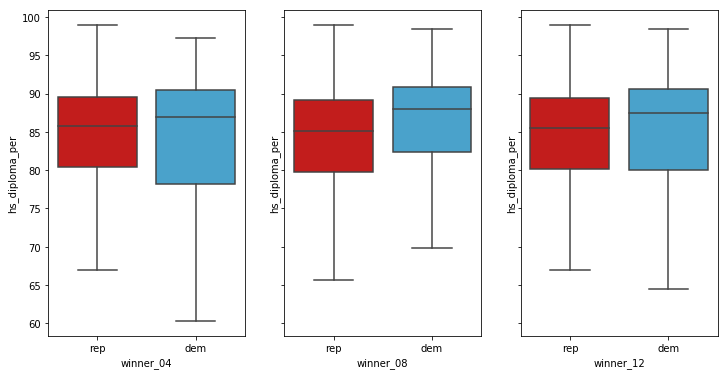

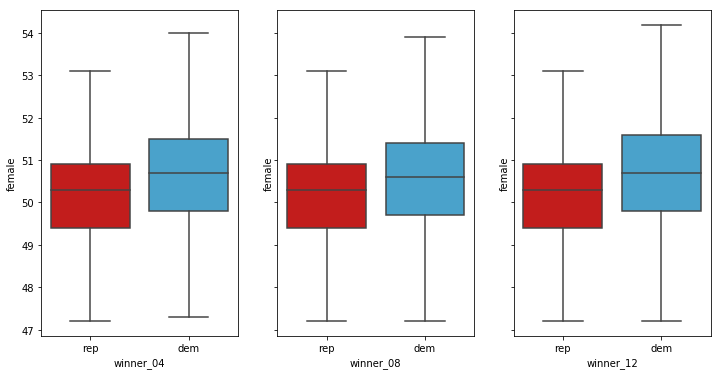

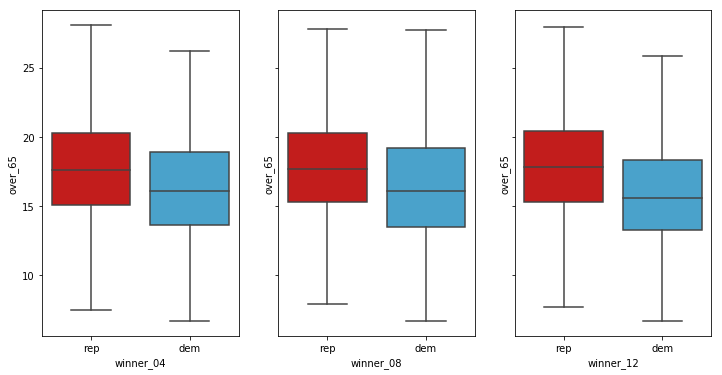

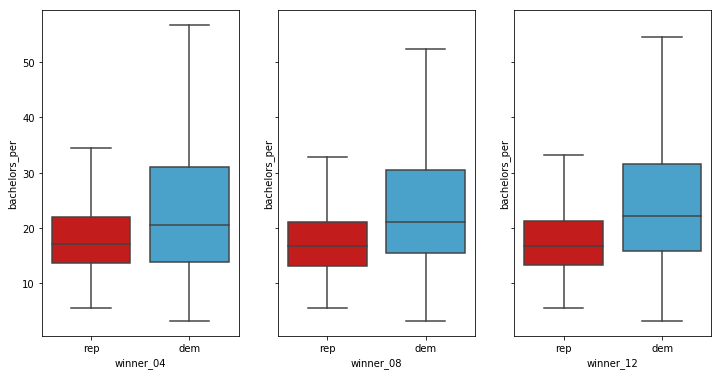

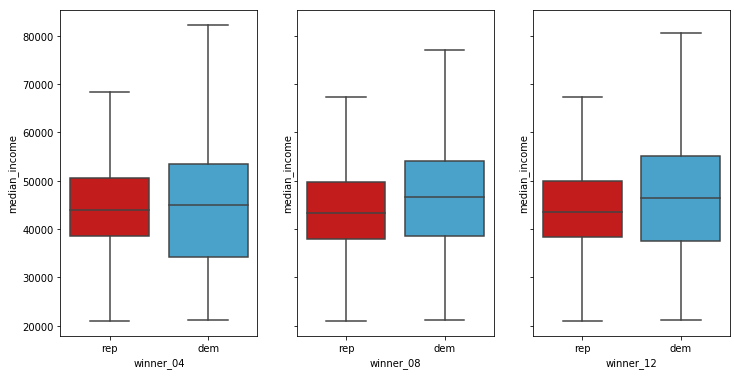

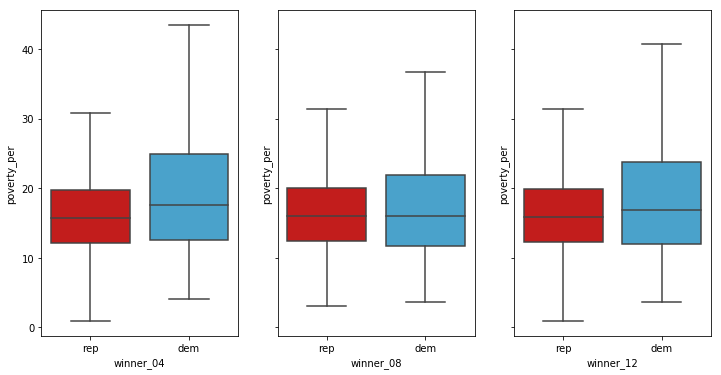

In [45]:
non_racial_demographic = ['hs_diploma_per', 'female', 'over_65', 'bachelors_per', 'median_income', 'poverty_per']
my_pal = {"rep": "#DE0100", "dem": "#34AAE0"}

for col in non_racial_demographic:
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey=True, figsize=(12,6))
    sns.boxplot(x = "winner_04",  y=col, data=election_full, palette=my_pal, ax=ax1, showfliers = False)
    sns.boxplot( x = "winner_08",  y=col, data=election_full, palette=my_pal, ax=ax2, showfliers = False)
    sns.boxplot(x = "winner_12",  y=col, data=election_full, palette=my_pal, ax = ax3, showfliers = False)

    plt.show()

  


Unlike with race/ethnicity above, we see no great changes in the county demographics year over year. If you squint, you can notice a similar trend to the race/ethnicity features: 2004 and 2012 looked more similar to each other than to 2008. I want to quickly look into the population numbers, as it seems we might have some 0's that don't make sense.

As we can see below, the low population counties seem to be plausibily low population and not bad data.


In [46]:
election_full[election_full.population_2010 < 500]

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,female,white,black,american_indian,asian,pacific_islander,two_plus_races,hispanic,white_alone_non_hisp,same_home_one_year_plus,foreign_born,bilingual,hs_diploma_per,bachelors_per,veterans,commute_time,housing_units,home_ownership,multi_unit_housing,median_home_value,households,person_per_household,per_capita_income,median_income,poverty_per,private_establishments,private_nonfarm_employemnt,non_farm_employment_change,non_employer_establishments,total_firms,black_firms,american_indian_firms,asian_firms,pacific_islander_firms,hispanic_firms,female_firms,manufacturing_shipments,wholesaling_sales,retail_sales,retail_sales_per_cap,hotel_food_sales,building_permits,land_area_sqmiles,pop_per_sm,vote_rep_04,vote_dem_04,vote_oth_04,total_votes_04,pct_rep_04,pct_dem_04,pct_oth_04,winner_04,runnerup_04,pct_winner_04,margin_04,vote_rep_08,vote_dem_08,vote_oth_08,total_votes_08,pct_rep_08,pct_dem_08,pct_oth_08,winner_08,runnerup_08,pct_winner_08,margin_08,vote_rep_12,vote_dem_12,vote_oth_12,total_votes_12,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04
1603,30069,Petroleum County,MT,485,494,-1.8,494,2.3,21.9,21.0,45.4,98.4,0.0,0.6,0.0,0.0,1.0,1.2,97.1,89.0,0.4,0.8,96.0,15.4,70,16.8,327,76.0,3.3,83200,233,2.31,22714,41705,11.1,11,0,0.0,40,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,409,0,1654.87,0.3,228,55,9,292,78.1,18.8,3.1,rep,dem,78.1,59.3,227,68,5,300,75.67,22.67,1.67,rep,dem,75.67,53.00,240.0,49.0,9.0,298.0,80.54,16.44,3.02,rep,dem,80.54,64.10,0.603239,0.607287,0.591093
1627,31005,Arthur County,NE,453,460,-1.5,460,5.7,28.0,21.2,51.9,96.7,0.2,0.4,0.2,0.0,2.4,5.1,93.2,81.2,0.0,2.4,94.5,31.7,31,20.7,252,61.6,0.4,76400,177,2.86,17656,40568,6.9,10,0,0.0,42,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,937,2519,0,0,715.36,0.6,240,24,2,266,90.2,9.0,0.8,rep,dem,90.2,81.2,217,39,7,263,82.51,14.83,2.66,rep,dem,82.51,67.68,227.0,30.0,5.0,262.0,86.64,11.45,1.91,rep,dem,86.64,75.19,0.569565,0.571739,0.578261
1629,31009,Blaine County,NE,504,478,5.4,478,8.3,23.4,21.8,48.0,98.8,0.2,0.2,0.0,0.0,0.8,0.2,98.6,88.1,1.2,0.7,99.0,16.0,46,22.4,323,58.2,0.8,57200,249,2.35,19141,42917,17.7,8,0,0.0,45,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,710.87,0.7,301,38,0,339,88.8,11.2,0.0,rep,dem,88.8,77.6,266,43,7,316,84.18,13.61,2.22,rep,dem,84.18,70.57,268.0,29.0,6.0,303.0,88.45,9.57,1.98,rep,dem,88.45,78.88,0.633891,0.661088,0.709205
2624,48261,Kenedy County,TX,400,416,-3.8,416,7.3,25.5,15.3,48.3,93.5,4.3,1.5,0.5,0.0,0.3,74.0,21.3,99.8,17.4,30.5,65.3,10.6,30,17.7,233,28.9,11.0,56200,159,3.28,15157,43438,32.8,13,107,1.9,16,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1458.33,0.3,82,85,2,169,48.5,50.3,1.2,dem,rep,50.3,1.8,94,108,0,202,46.53,53.47,0.00,dem,rep,53.47,6.94,84.0,82.0,1.0,167.0,50.30,49.10,0.60,rep,dem,50.30,1.20,0.401442,0.485577,0.406250
2628,48269,King County,TX,262,286,-8.4,286,7.6,20.6,17.6,50.4,95.4,0.0,1.5,0.0,0.0,3.1,17.2,79.0,90.6,17.1,23.6,81.7,20.5,6,11.2,186,42.1,6.5,91000,126,2.53,29836,65000,5.9,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,910.87,0.3,137,18,1,156,87.8,11.5,0.6,rep,dem,87.8,76.3,151,8,4,163,92.64,4.91,2.45,rep,dem,92.64,87.73,139.0,5.0,1.0,145.0,95.86,3.45,0.69,rep,dem,95.86,92.41,0.506993,0.569930,0.545455
2644,48301,Loving County,TX,86,82,4.9,82,9.3,30.2,15.1,41.9,96.5,0.0,3.5,0.0,0.0,0.0,20.9,75.6,83.9,0.0,0.0,89.5,7.9,2,24.5,50,48.5,4.8,86000,33,2.64,34068,68750,12.0,2,0,0.0,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,668.93,0.1,65,12,3,80,81.3,15.0,3.8,rep,dem,81.3,66.3,67,12,0,79,84.81,15.19,0.00,rep,dem,84.81,69.62,54.0,9.0,1.0,64.0,84.38,14.06,1.56,rep,dem,84.38,70.32,0.780488,0.963415,0.975610


In [47]:
cols =['turnout_12', 'turnout_08', 'turnout_04']
for col in cols:
    election_features[col] = election_features[col].apply(lambda x: 1 if x > 1 else x)


Now, let's work towards building a model and identifying what features were most important to the 2012 election. We'll drop our non-outcome 2012 data, run some t-tests, create categorical features, and then view correlations and hopefully trim down the dataset to a smaller number of features. 

In [48]:
election_features = election_full.drop(['vote_rep_04','vote_dem_04','vote_oth_04','total_votes_04','pct_rep_04',
                                       'pct_dem_04','pct_oth_04','runnerup_04','pct_winner_04','vote_rep_08',
                                       'vote_dem_08','vote_oth_08','total_votes_08','pct_rep_08',
                                       'pct_dem_08','pct_oth_08','runnerup_08','pct_winner_08','vote_rep_12',
                                       'vote_dem_12','vote_oth_12','total_votes_12','pct_rep_12','pct_dem_12',
                                       'pct_oth_12','runnerup_12','pct_winner_12', 'fips','county','state'],
                                        axis = 1)
#election_features.drop(['fips','county','state'], axis =1, inplace = True) # add this back on next pass

election_features['winner_12']= election_features['winner_12'].apply(lambda x: 1 if x == 'dem' else 0)
election_features['winner_08']= election_features['winner_08'].apply(lambda x: 1 if x == 'dem' else 0)
election_features['winner_04']= election_features['winner_04'].apply(lambda x: 1 if x == 'rep' else 0)


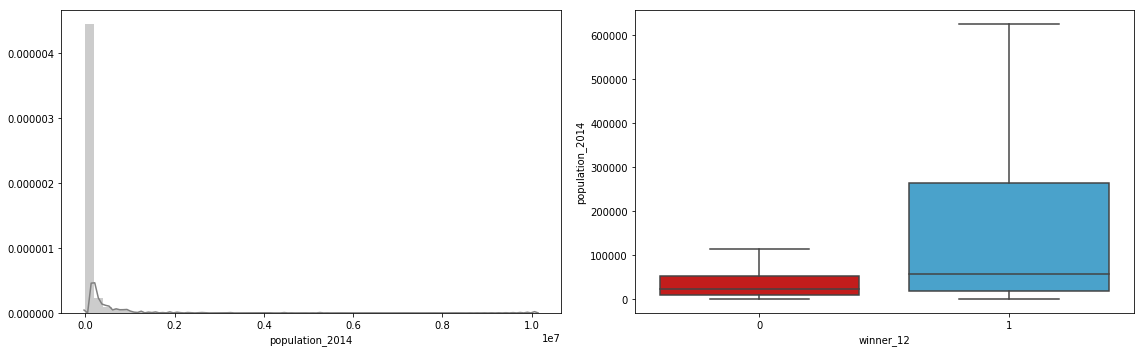

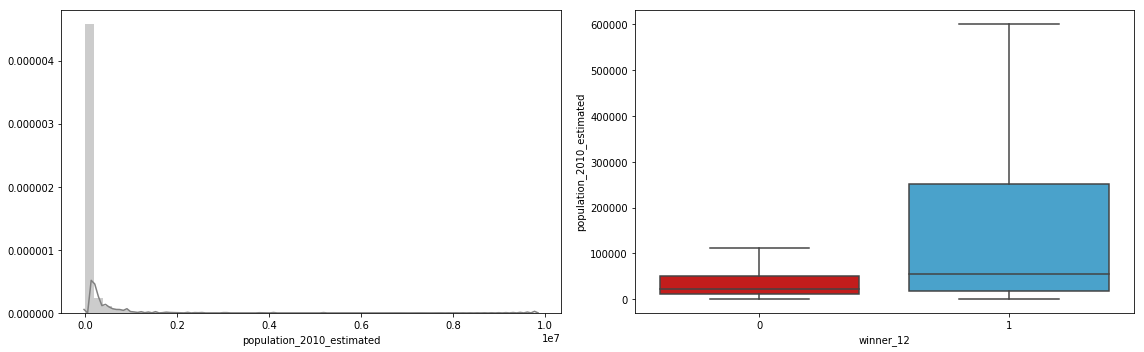

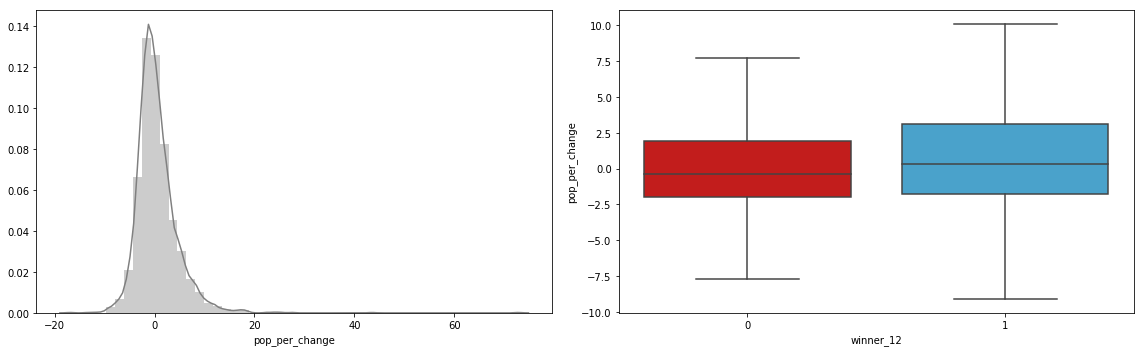

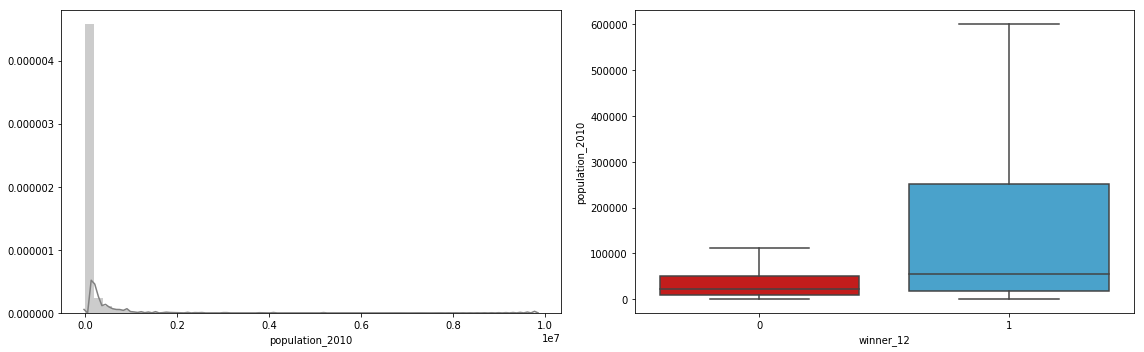

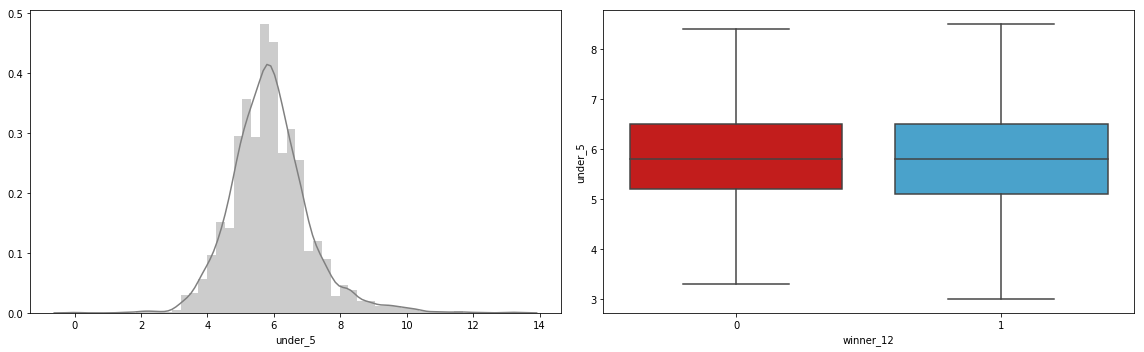

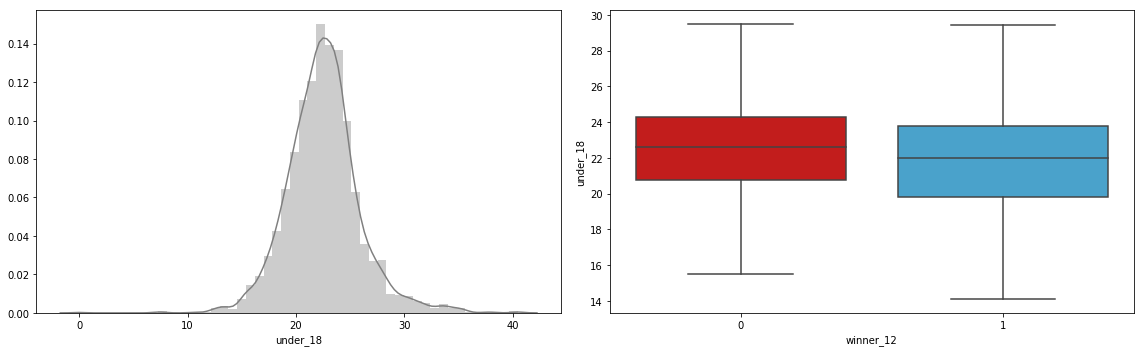

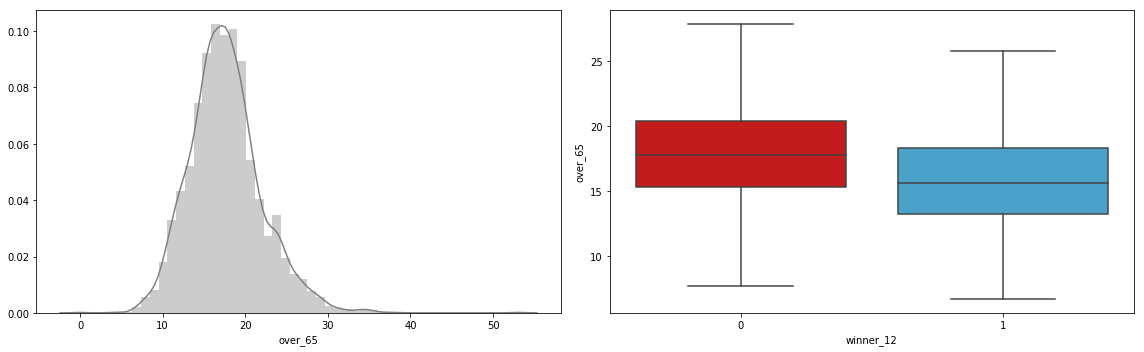

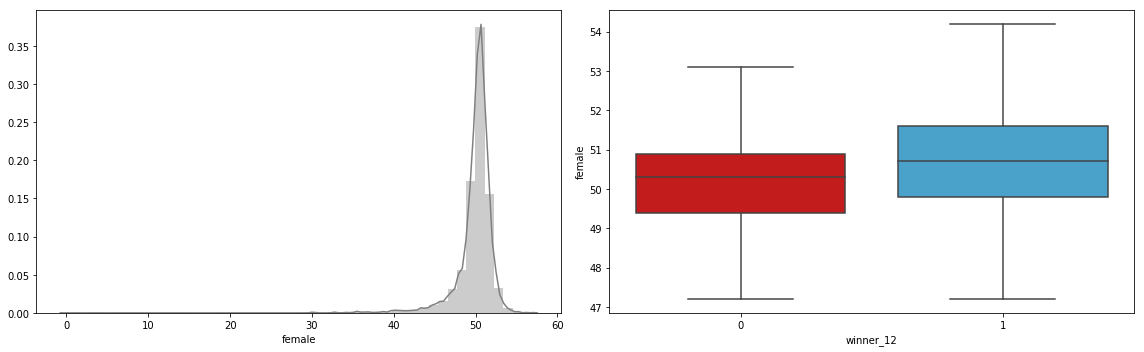

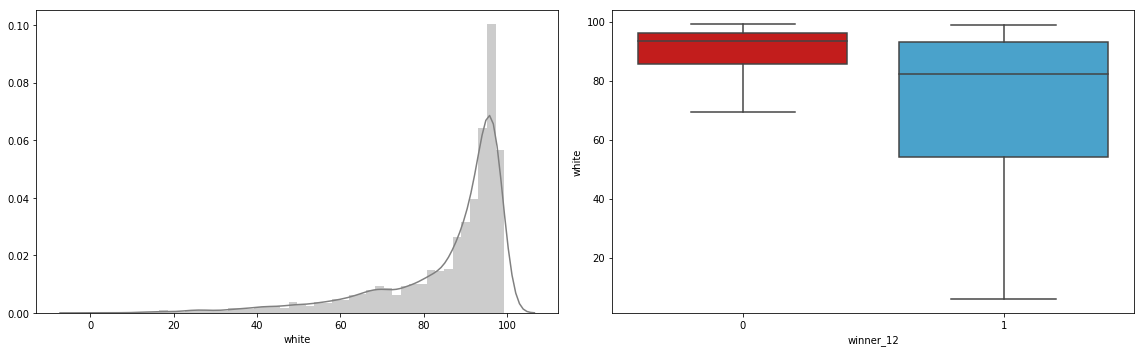

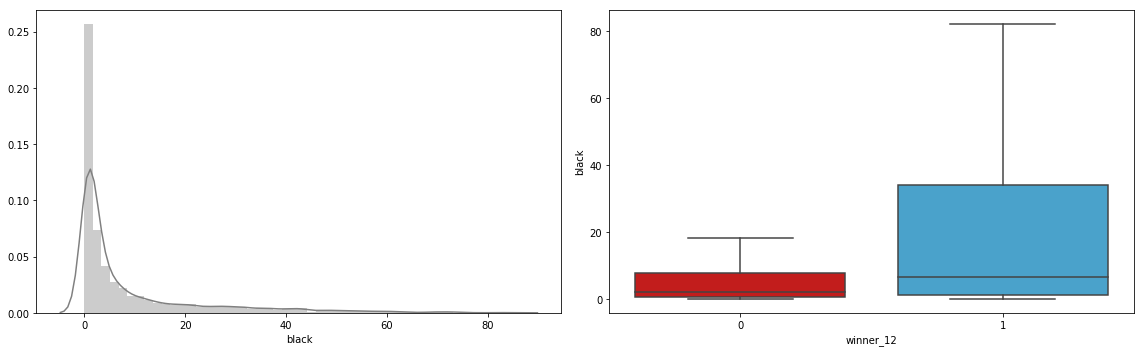

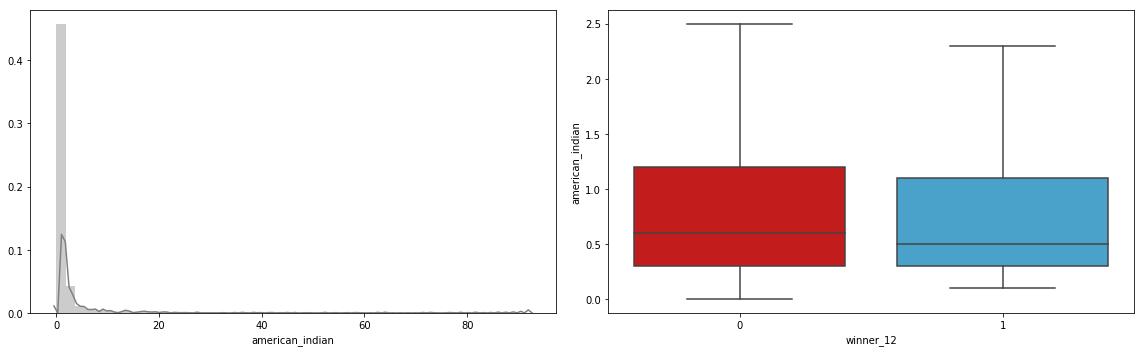

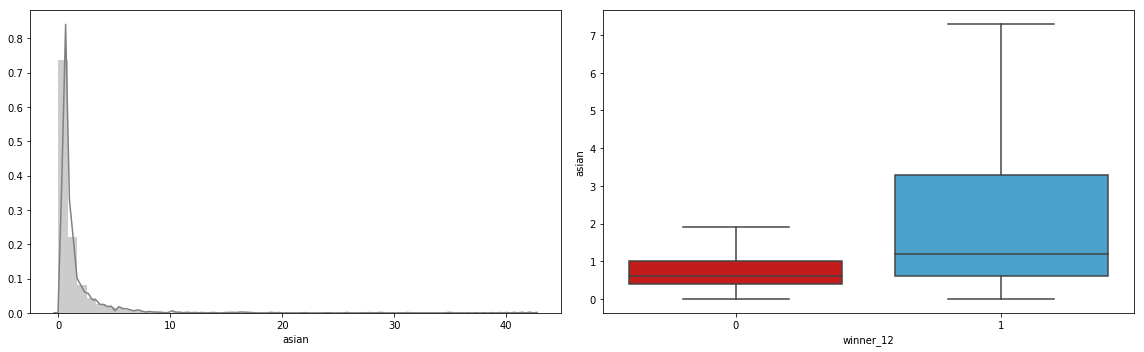

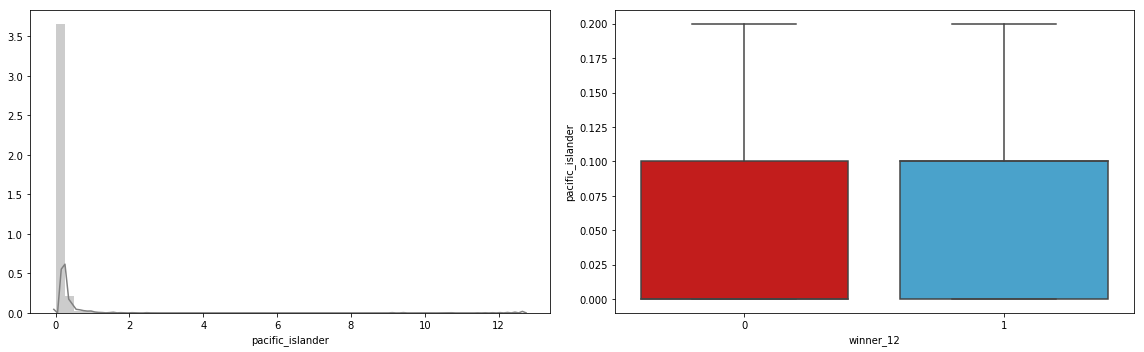

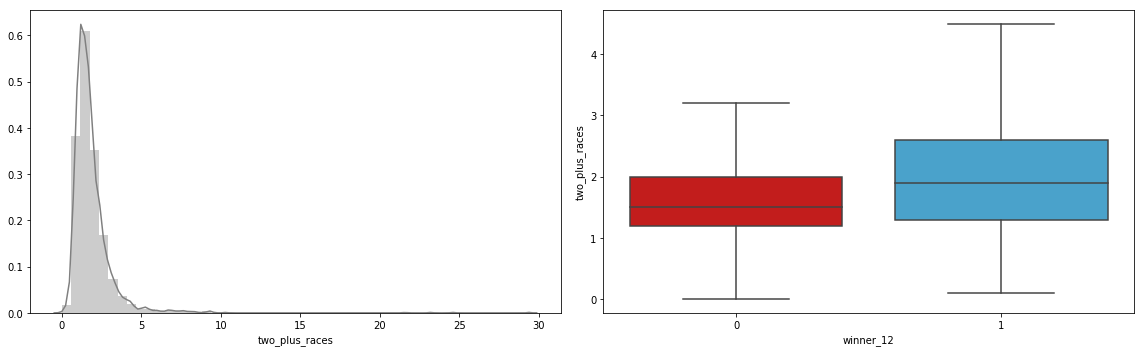

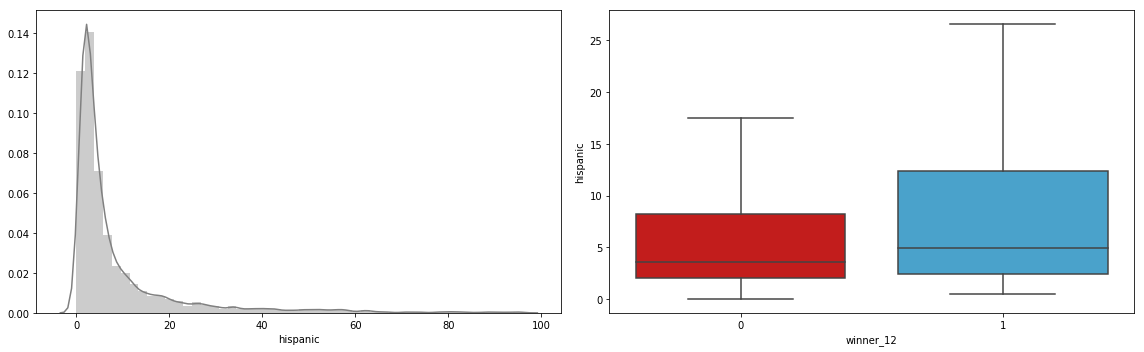

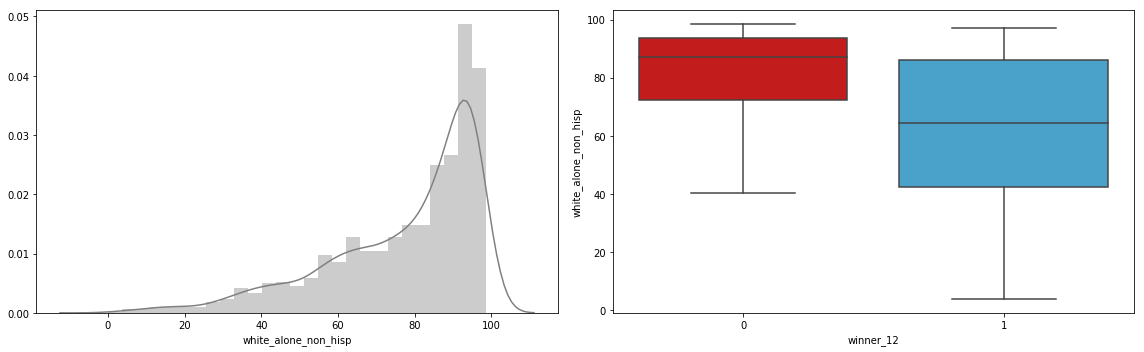

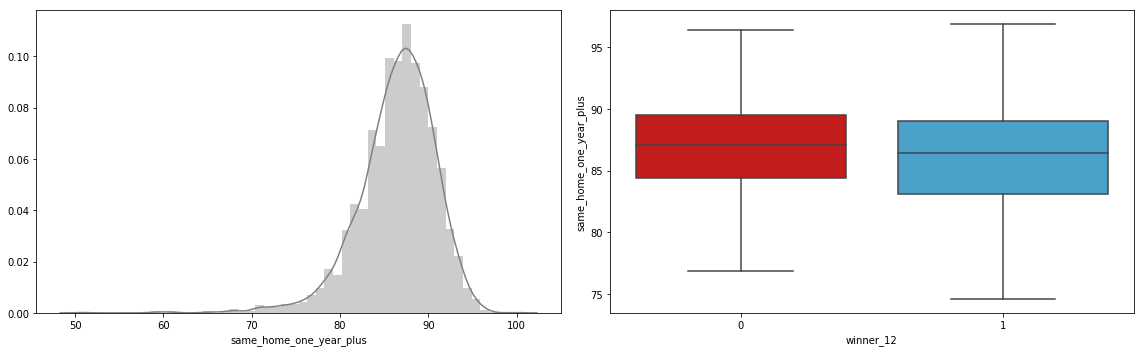

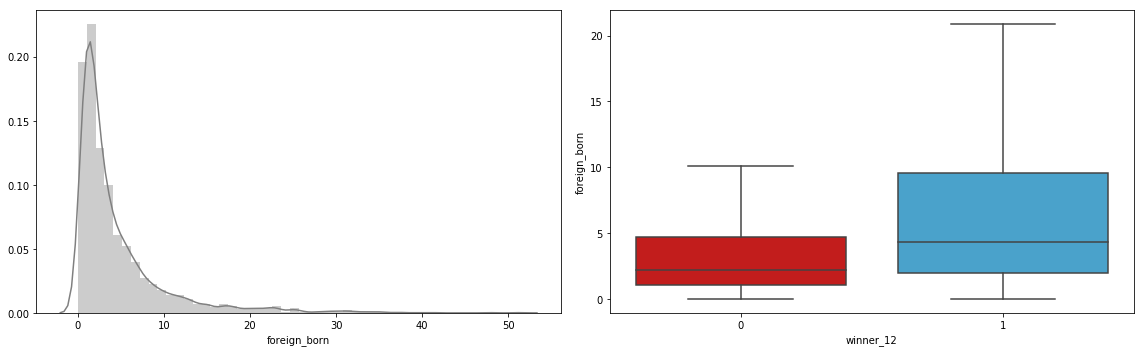

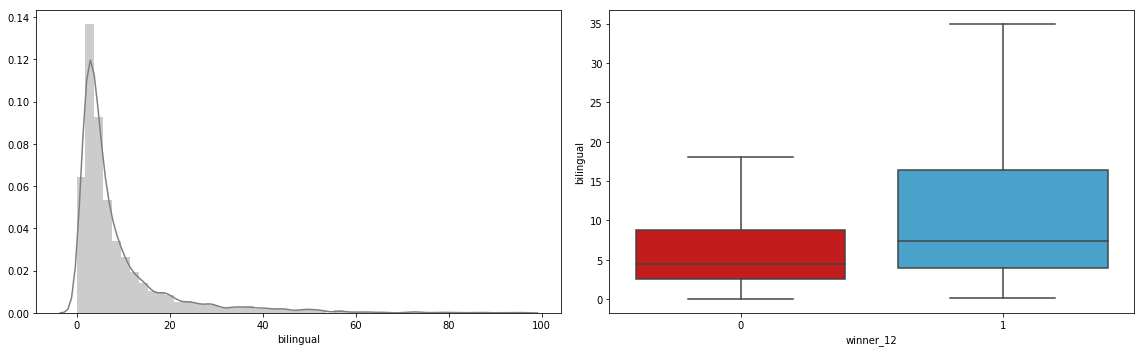

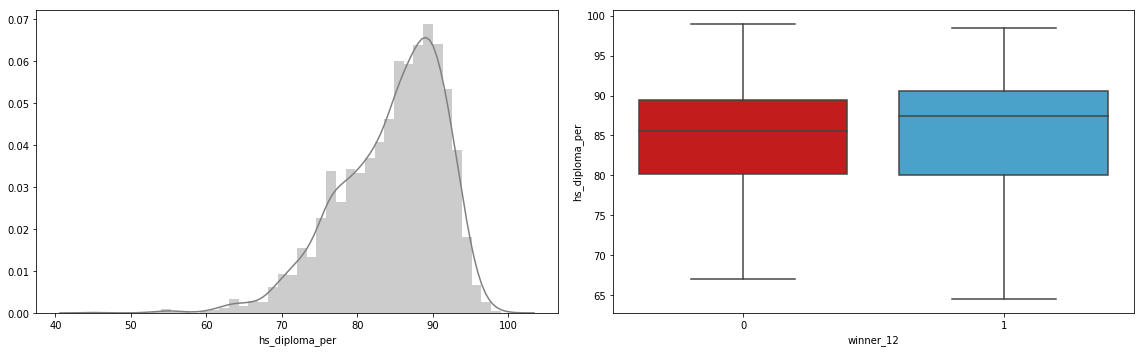

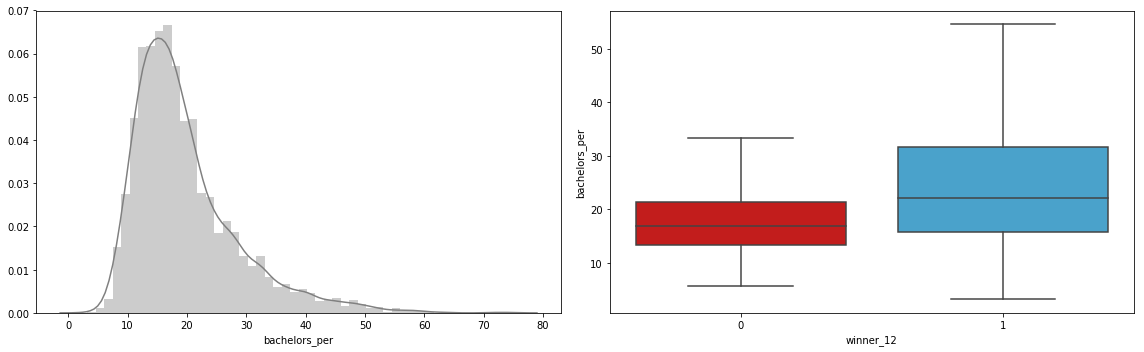

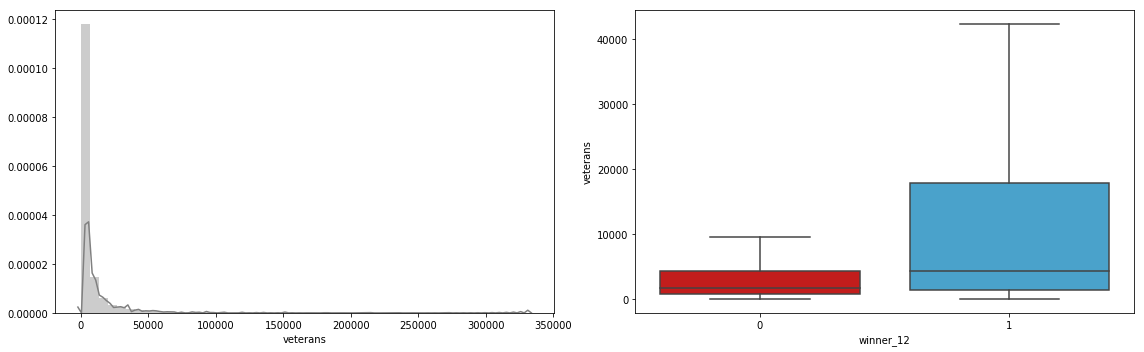

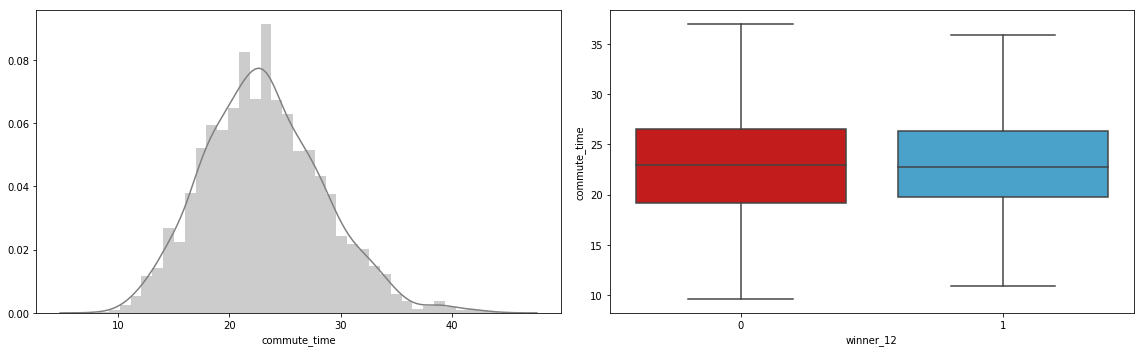

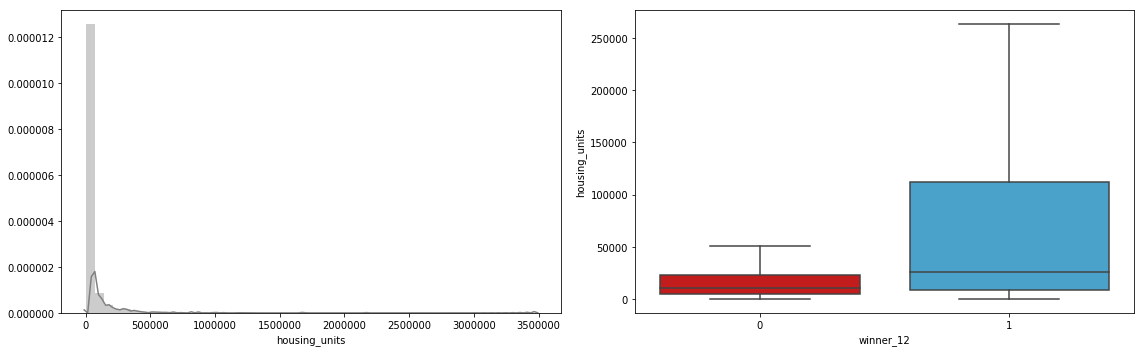

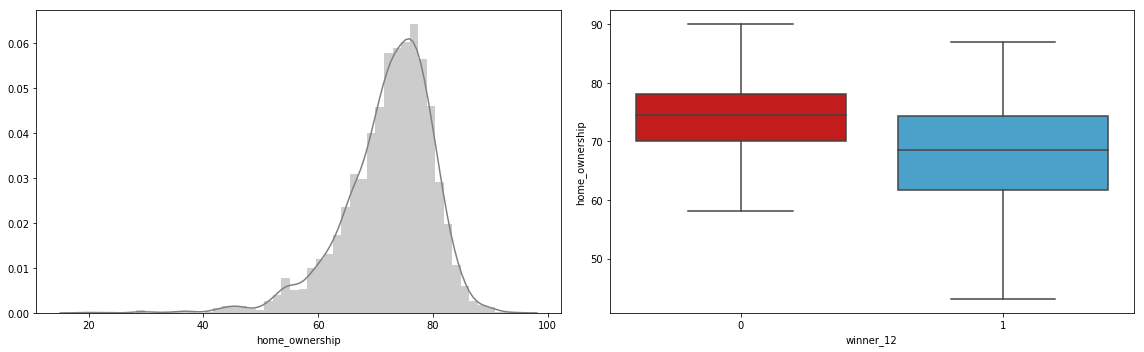

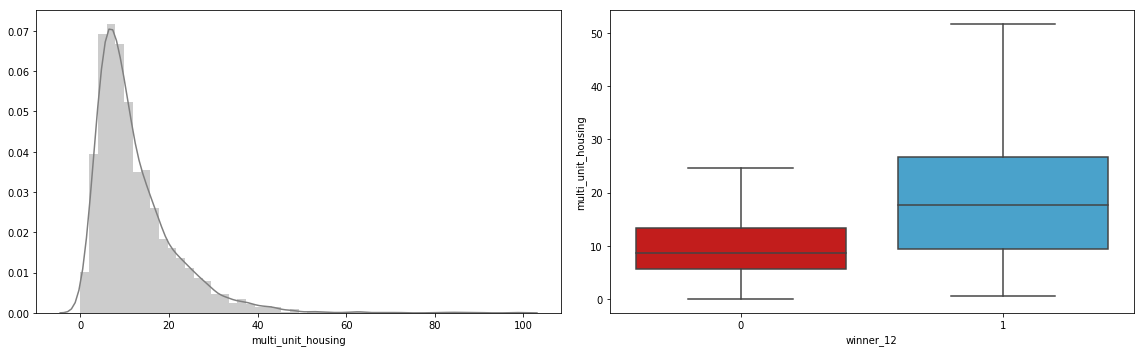

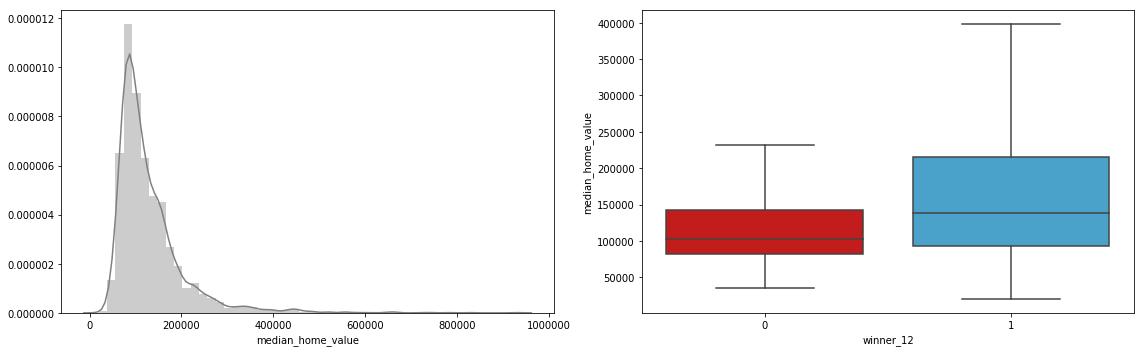

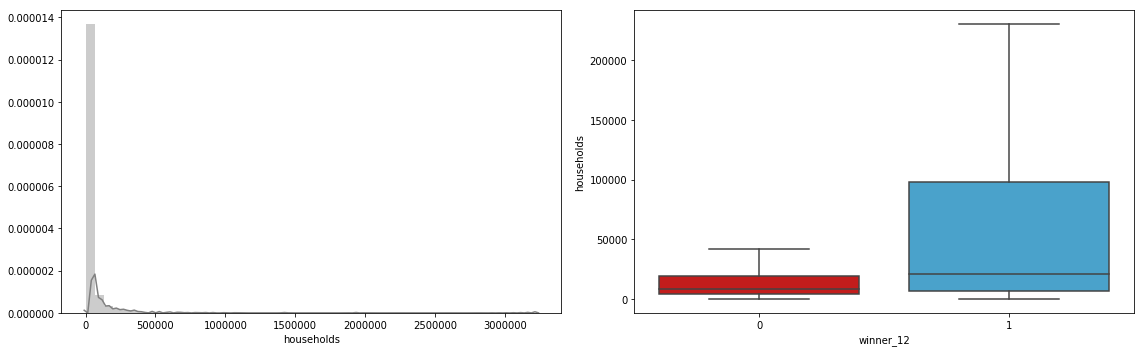

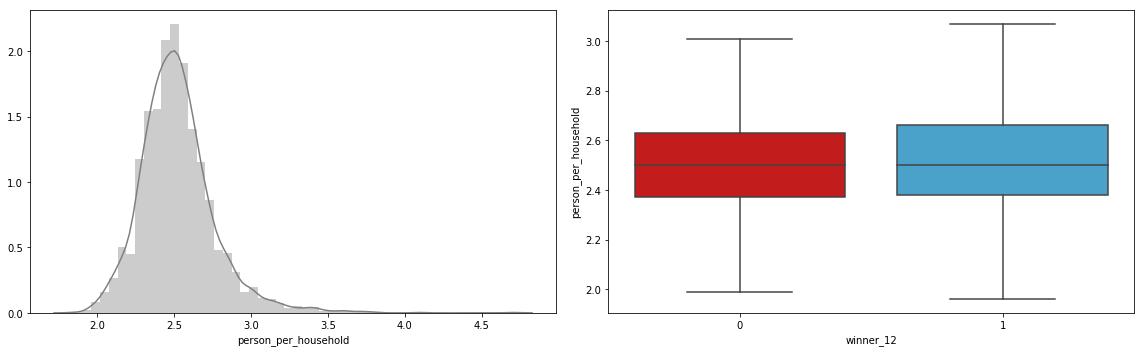

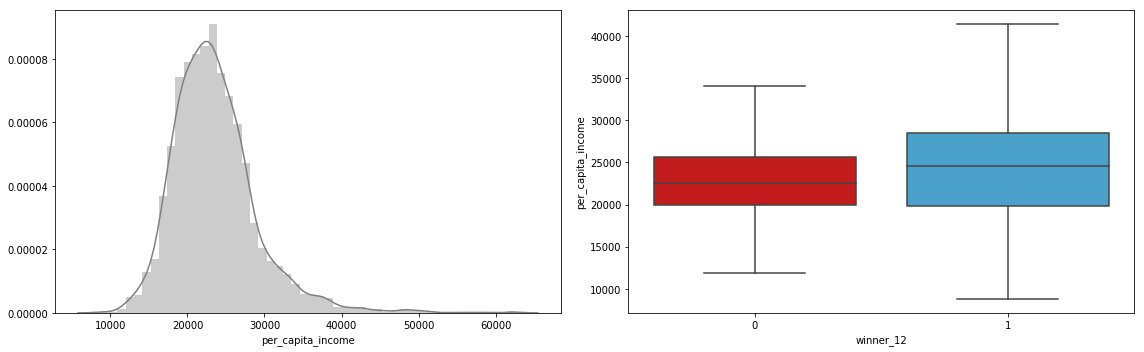

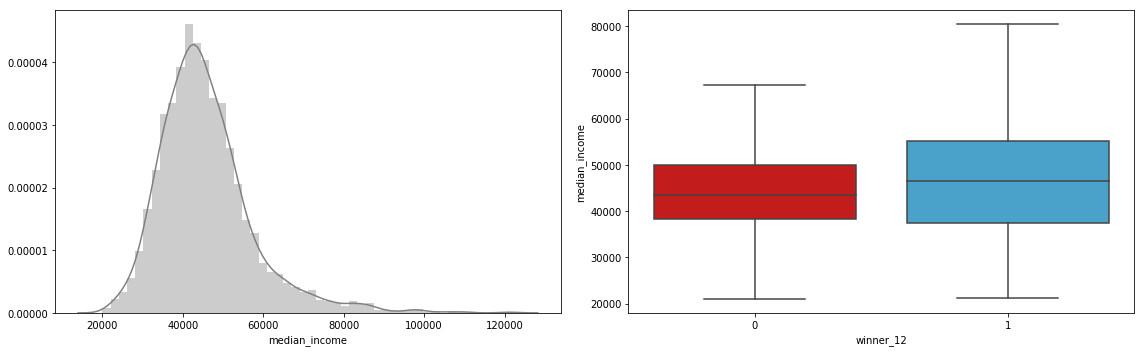

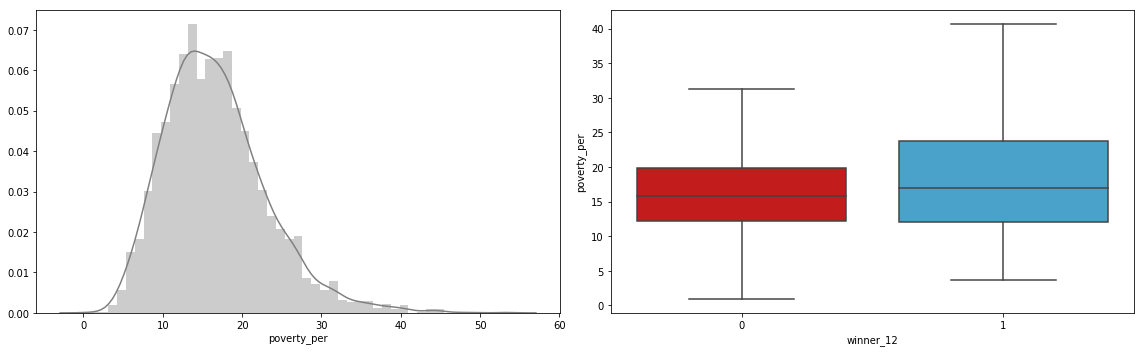

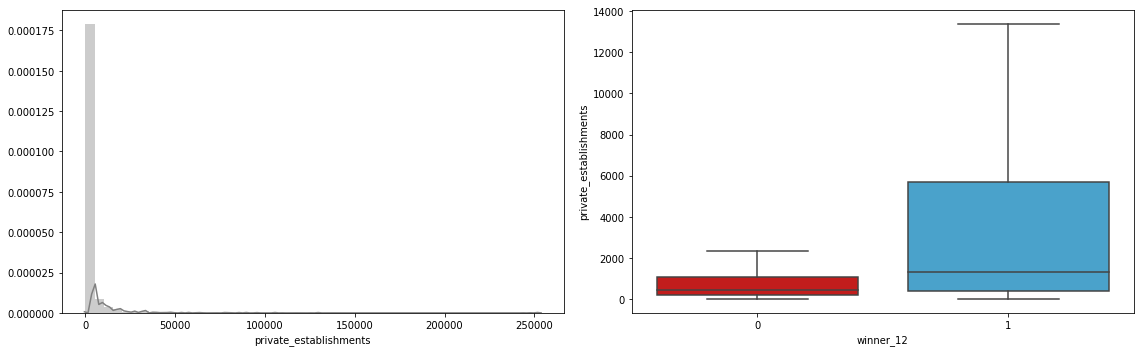

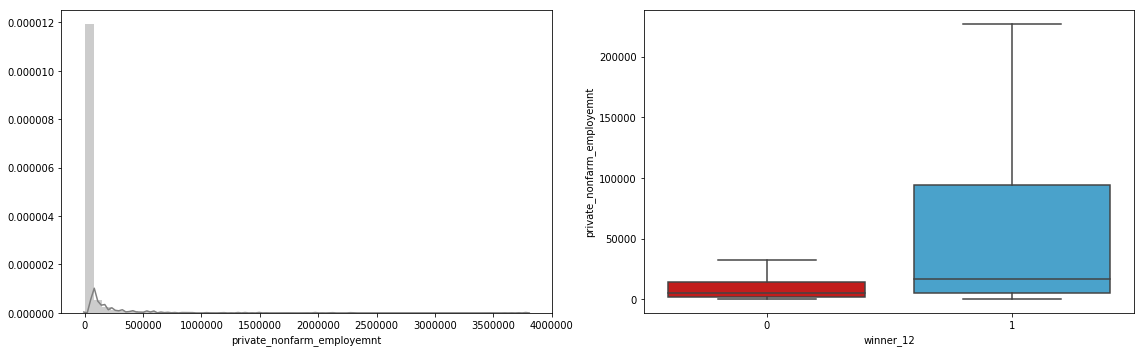

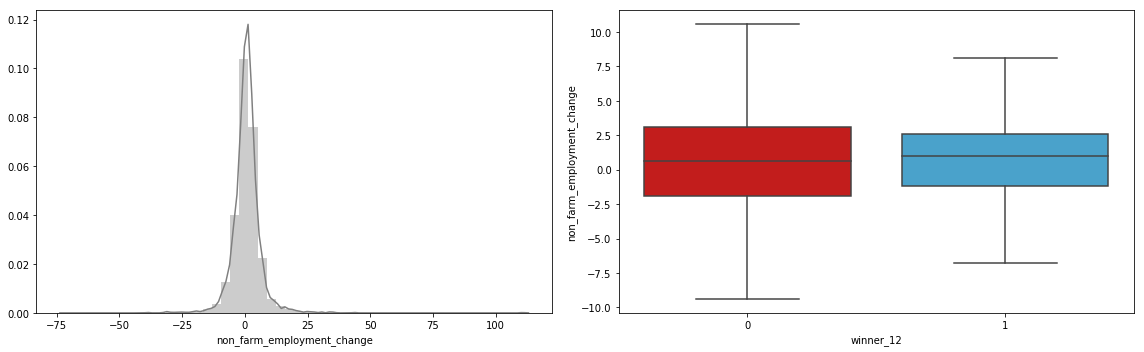

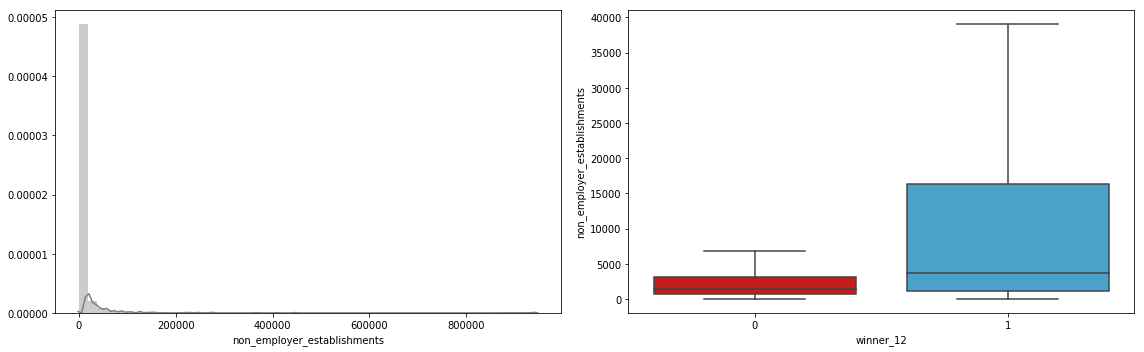

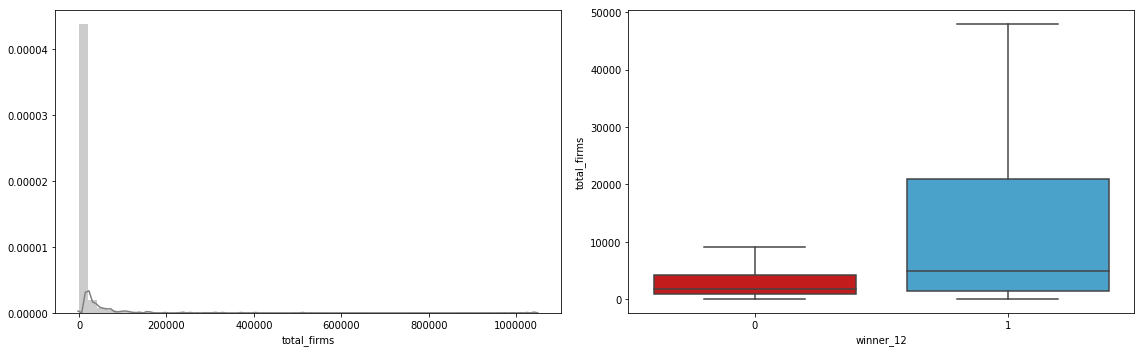

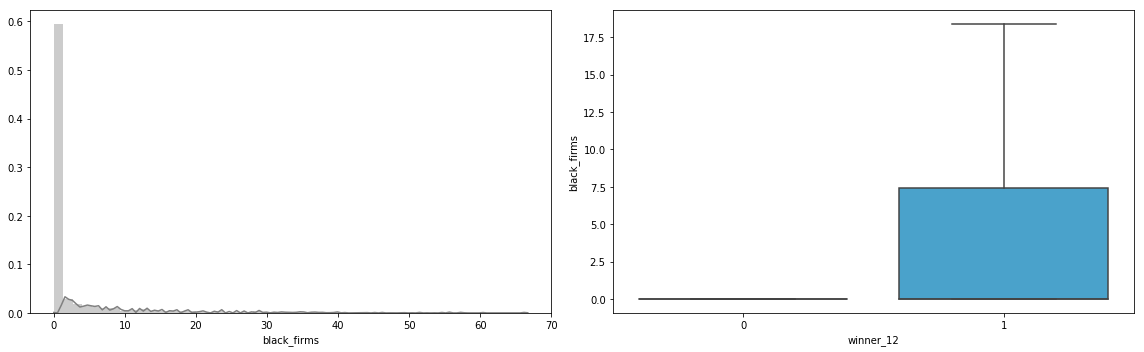

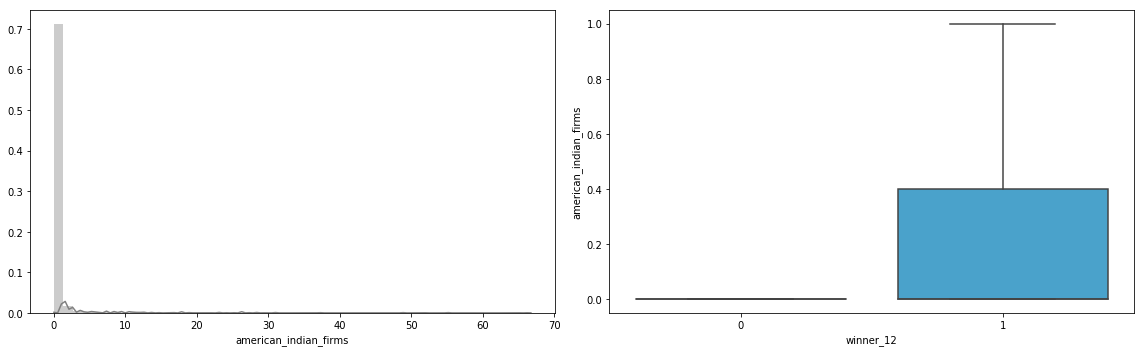

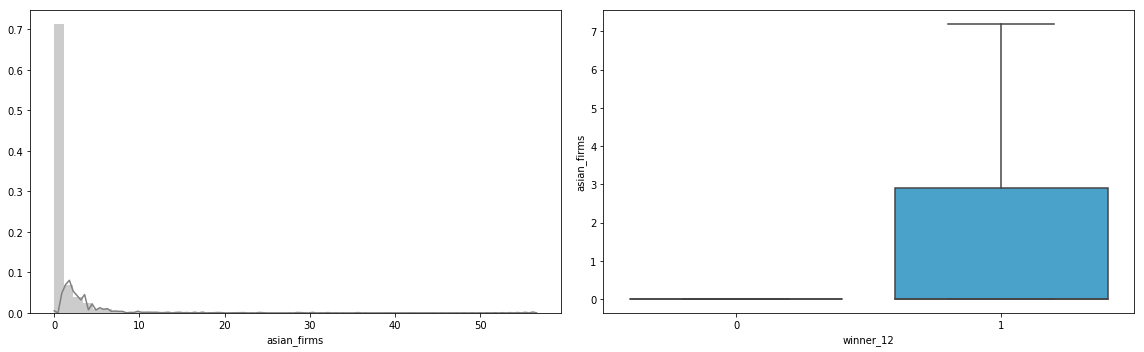

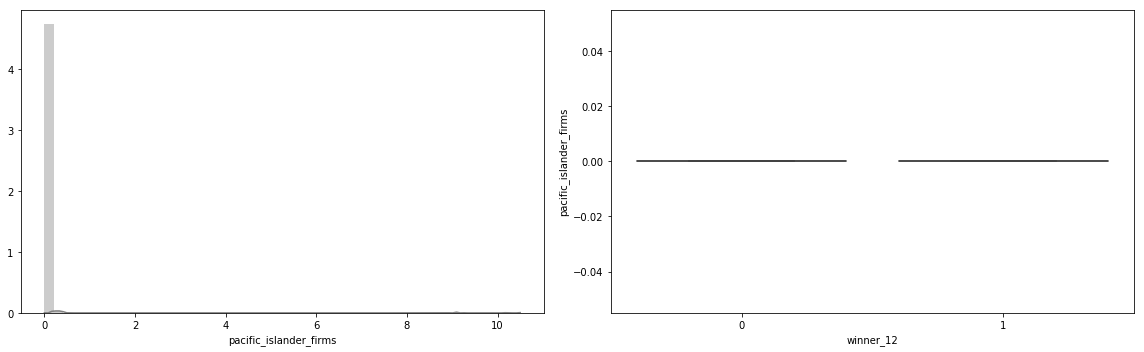

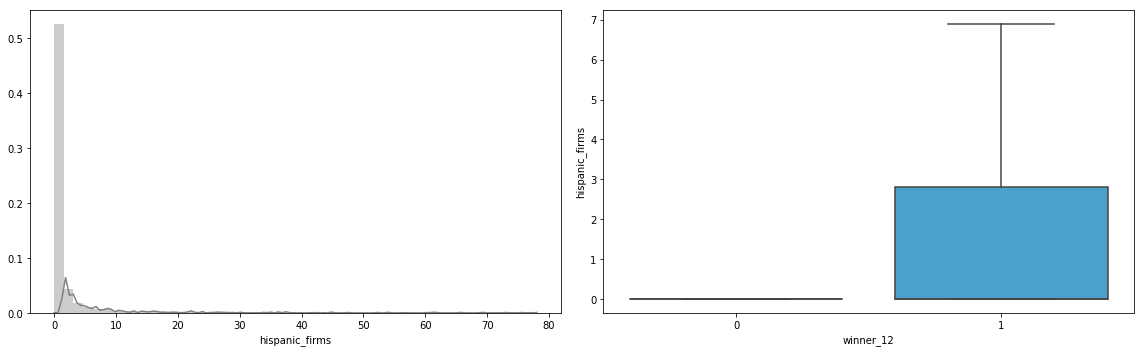

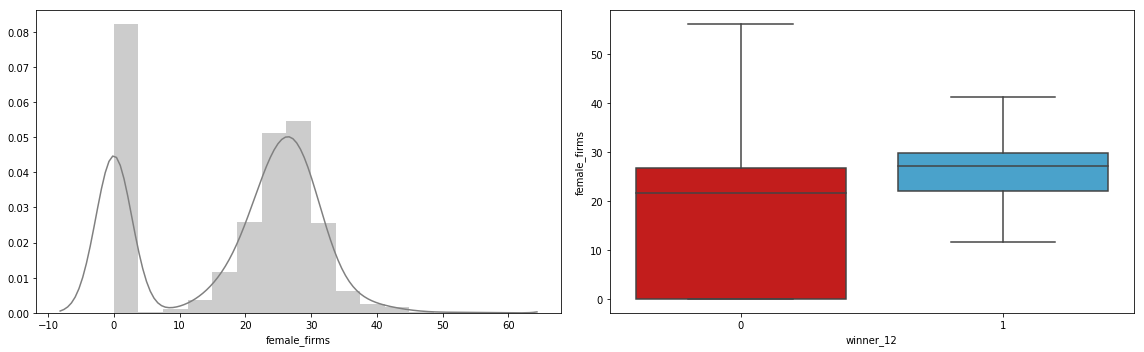

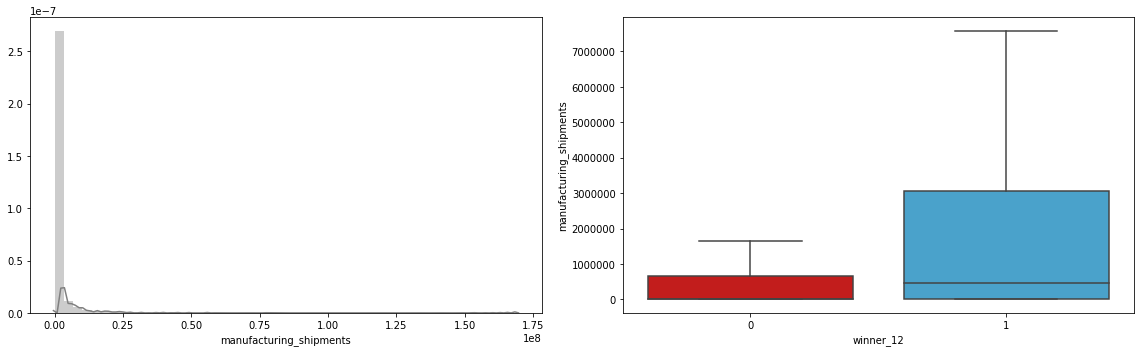

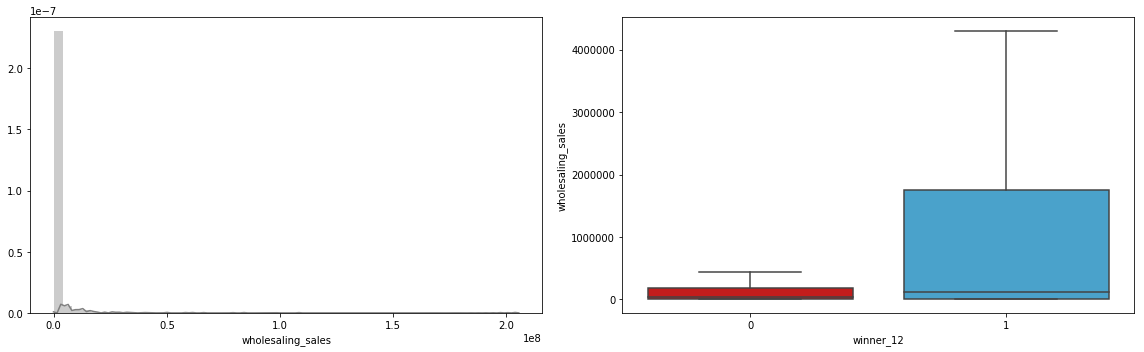

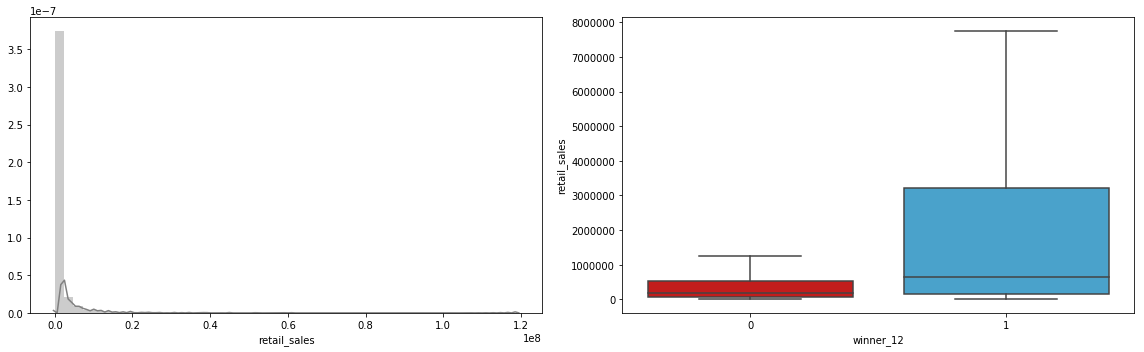

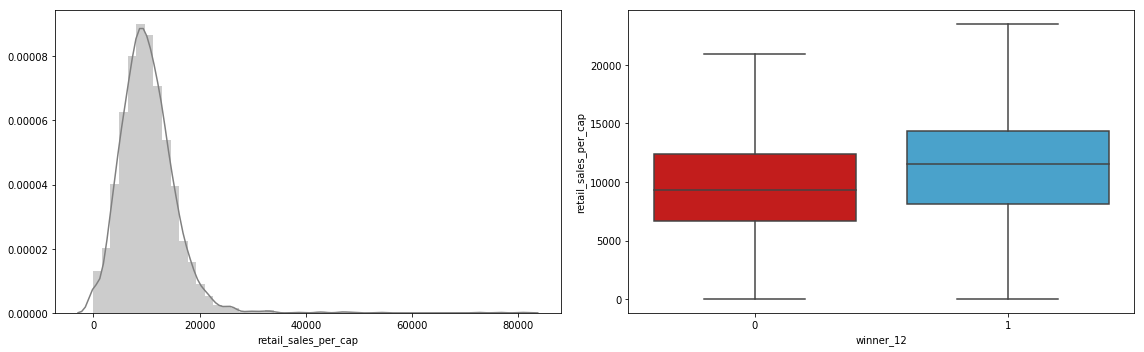

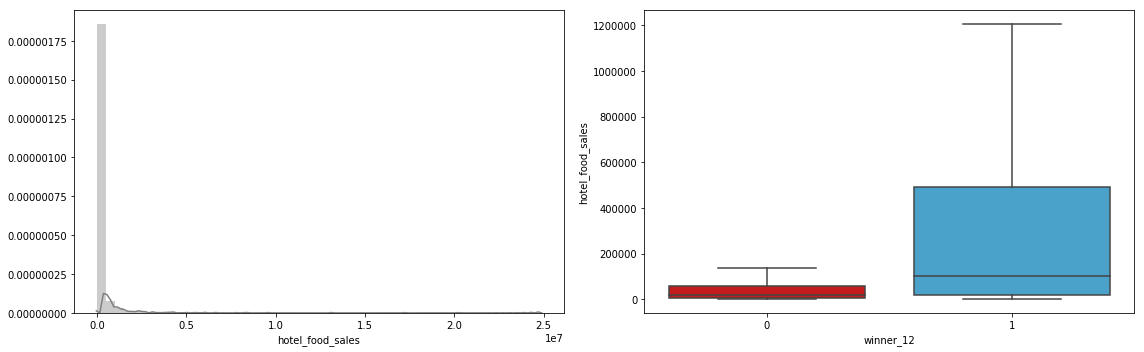

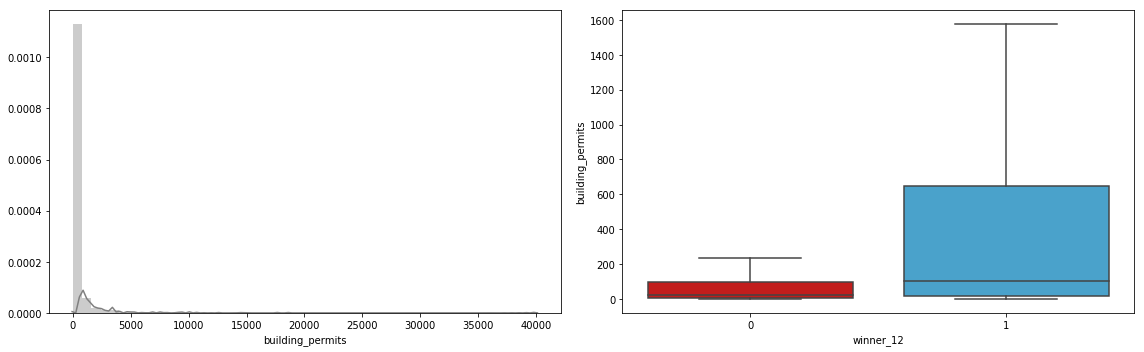

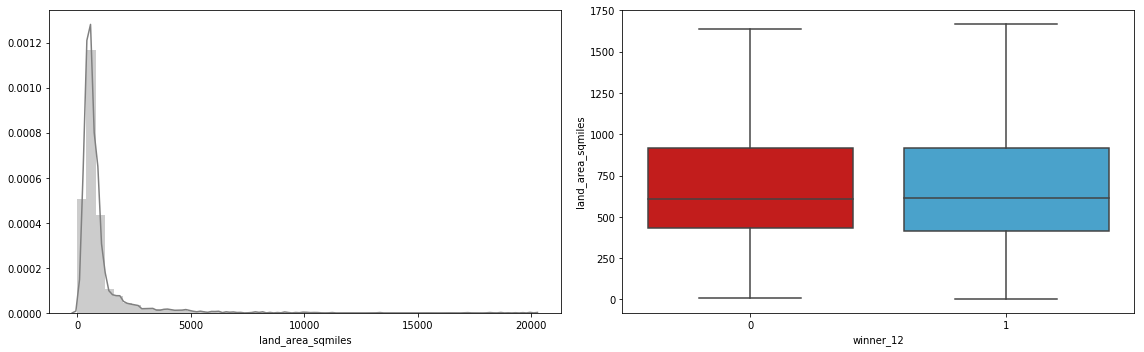

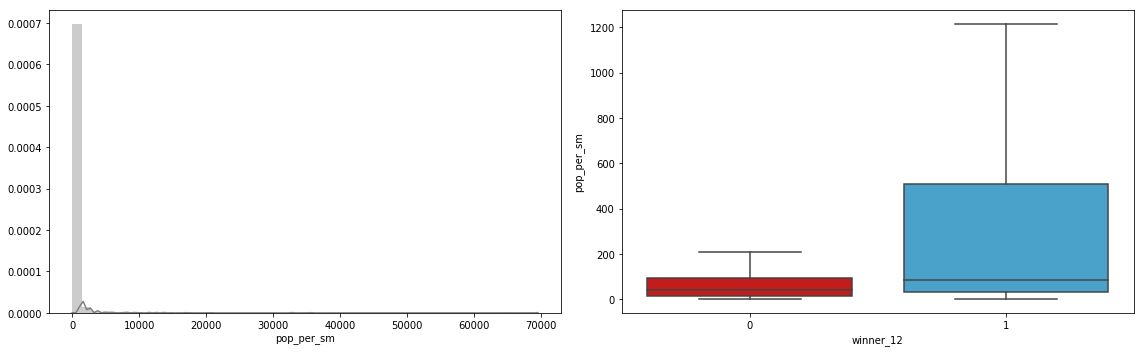

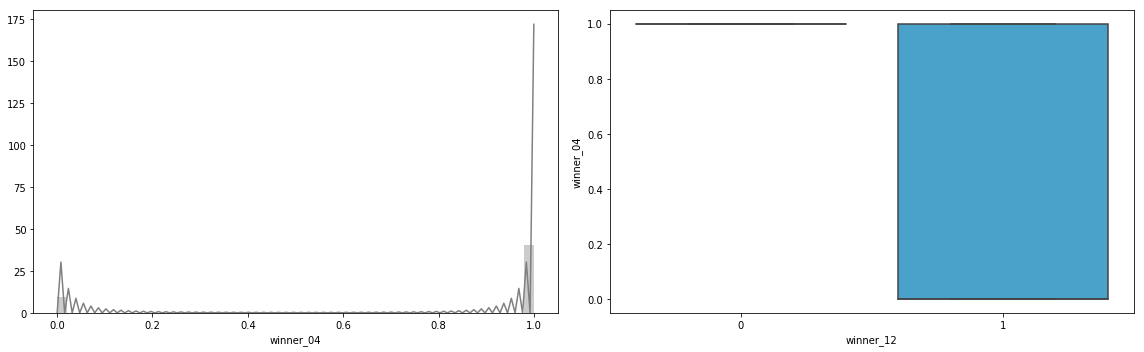

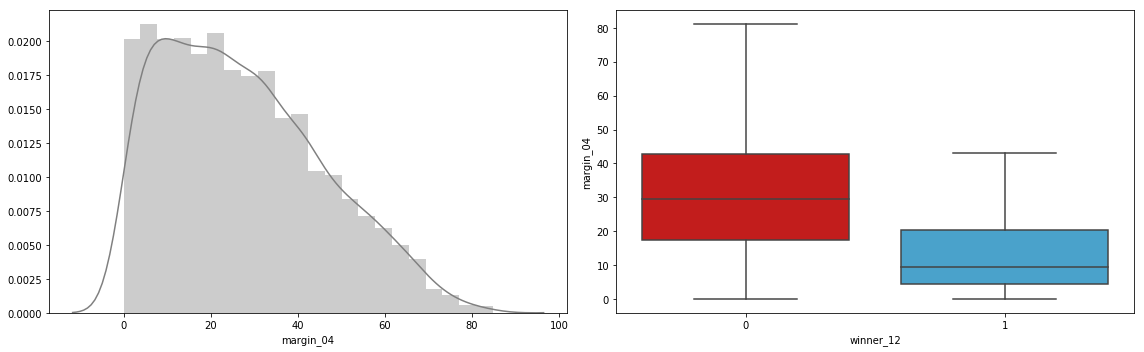

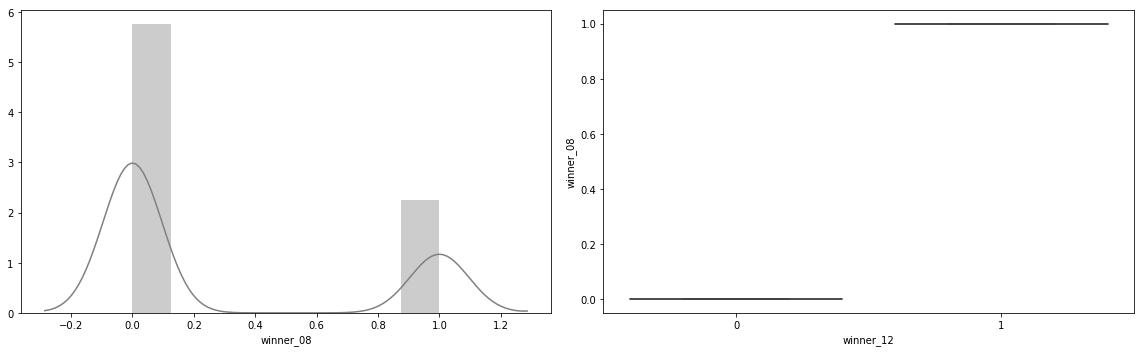

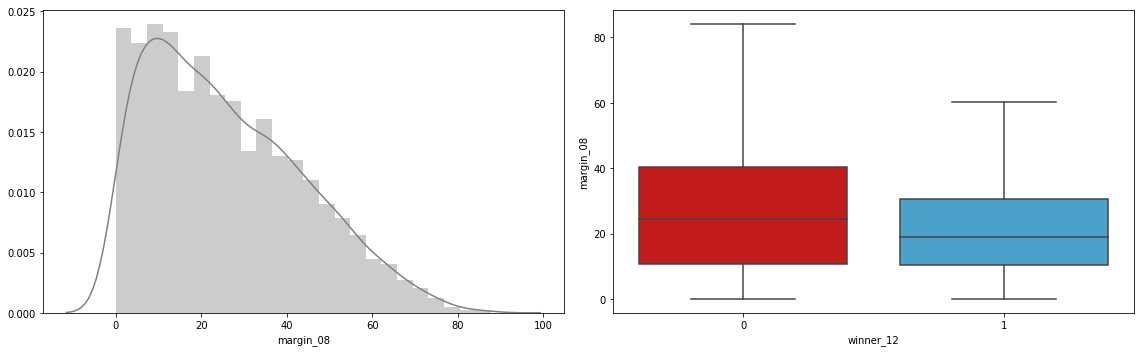

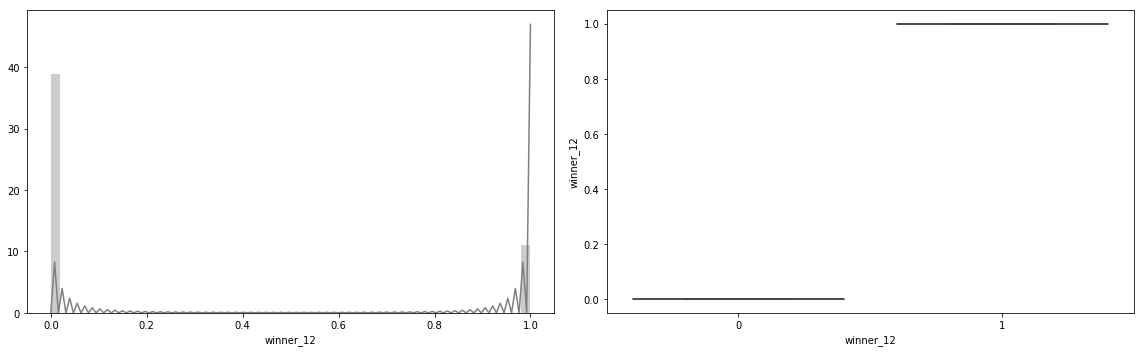

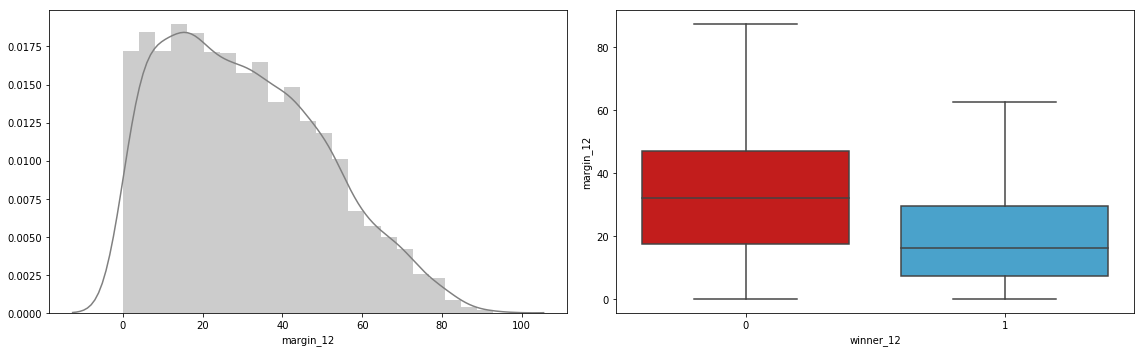

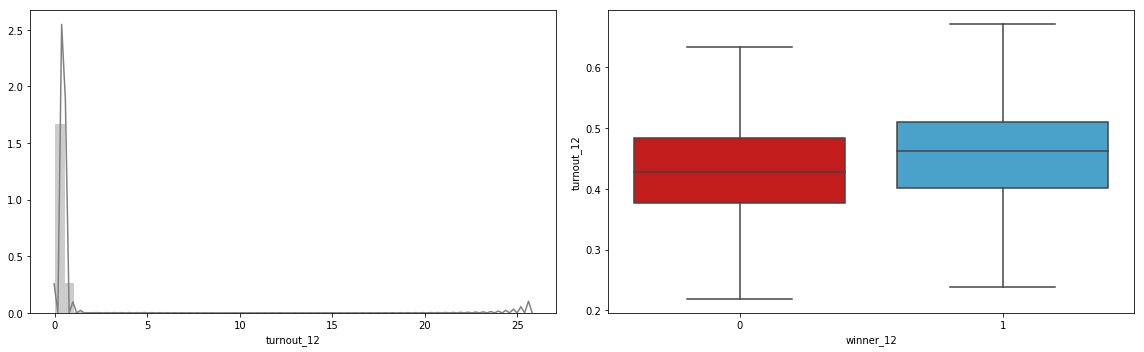

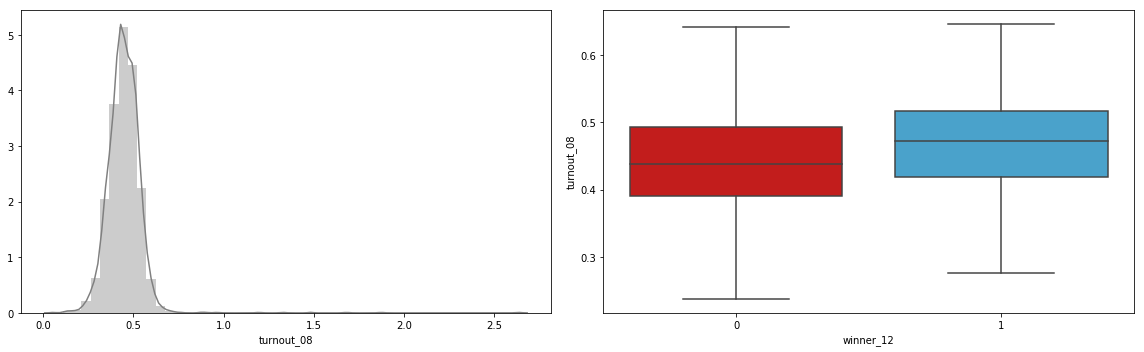

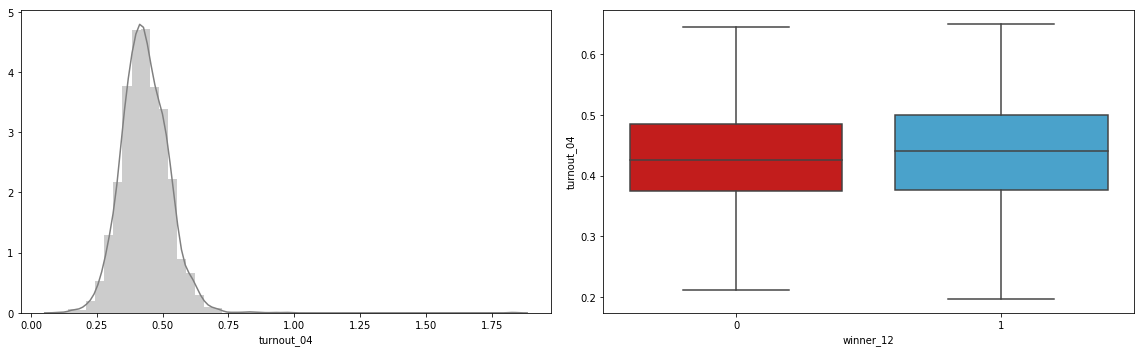

In [49]:
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

my_pal_binary = {0: "#DE0100", 1: "#34AAE0"}


p_vals = pd.DataFrame(columns=['Feature', 'P_value'])
vals = pd.DataFrame(columns=['Feature', 'value'])
u_vals = pd.DataFrame(columns=['Feature', 'U_value'])

for col in election_features.columns: #initialize loop 
    
    plt.figure(figsize=(16,5))
    plt.subplot(121)
    sns.distplot(election_features[col], color = 'gray')
    
    plt.subplot(122)
    sns.boxplot(x="winner_12", y=col, data=election_features, palette = my_pal_binary, showfliers = False)
    
    plt.tight_layout()
    plt.show()
    
   
   
    
    _,val = stats.normaltest(election_features[col]) 
    if val >= .05:
        vals = vals.append({'Feature':col, 'value':float(val)}, ignore_index=True)
    else:
        pass
       
    _, p_val = ttest_ind(election_features[election_features['winner_12']==0][col],
                             election_features[election_features['winner_12']==1][col])
    if p_val >= .05:
        p_vals = p_vals.append({'Feature':col, 'P_value':float(p_val)}, ignore_index=True)
    else:
        pass
    
    _,u_val = stats.mannwhitneyu(election_features[election_features['winner_12']==0][col],
                             election_features[election_features['winner_12']==1][col])
    if u_val >= .05:
        u_vals = u_vals.append({'Feature':col, 'U_value':float(u_val)}, ignore_index=True)
    else:
        pass





In [50]:
print(vals.sort_values('value'))
print(p_vals.sort_values('P_value'))
u_vals.sort_values('U_value')


Empty DataFrame
Columns: [Feature, value]
Index: []
                      Feature   P_value
0              pop_per_change  0.058057
1                     under_5  0.104816
2                commute_time  0.218174
6                  turnout_04  0.240580
4           land_area_sqmiles  0.353029
3  non_farm_employment_change  0.623606
5                  turnout_12  0.706491


,Feature,U_value
3,person_per_household,0.060402
4,non_farm_employment_change,0.131771
5,land_area_sqmiles,0.159092
1,american_indian,0.205399
2,commute_time,0.234595
0,under_5,0.370117


Looks like we have a lot of choices to make. Unfortunately turnout_04 doesn't make the cut and we have other features that didn't distinguish themselves.

We'll drop the features that didn't pass the t-test or Mann Whitney test and use RFE to make these seemingly random choices for us later.



In [51]:
election_features.drop(['pop_per_change','person_per_household','non_farm_employment_change',
                    'land_area_sqmiles', 'american_indian', 'commute_time', 'under_5','turnout_04' ],
                   axis =1, inplace = True)

In [52]:
election_features.shape

(3111, 52)

-------- four-panel Plot for population_2014----------


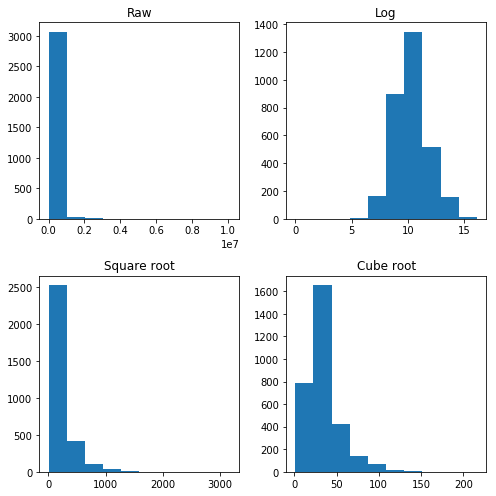

-------- four-panel Plot for population_2010_estimated----------


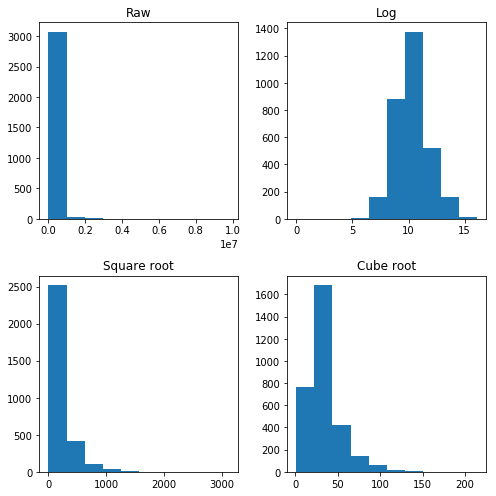

-------- four-panel Plot for population_2010----------


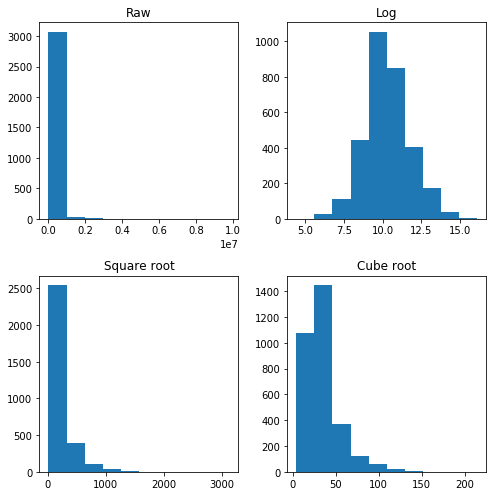

-------- four-panel Plot for under_18----------


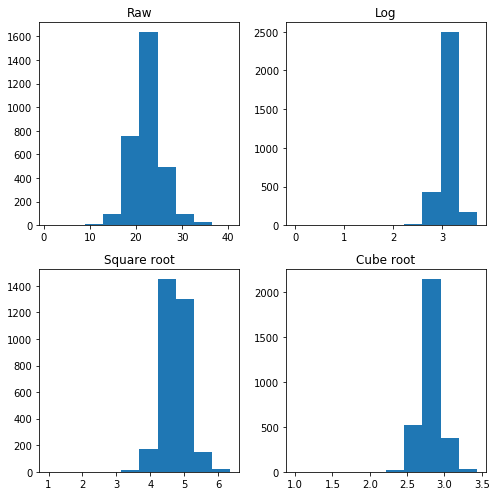

-------- four-panel Plot for over_65----------


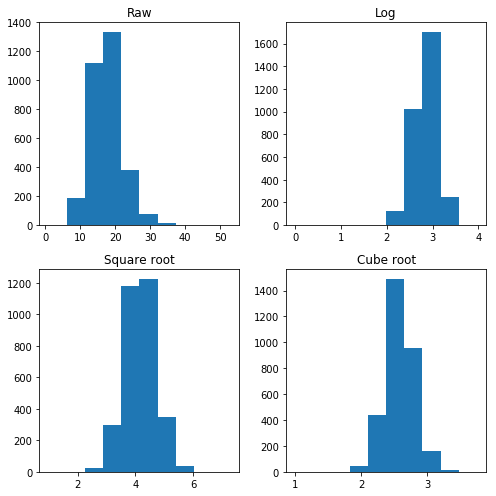

-------- four-panel Plot for female----------


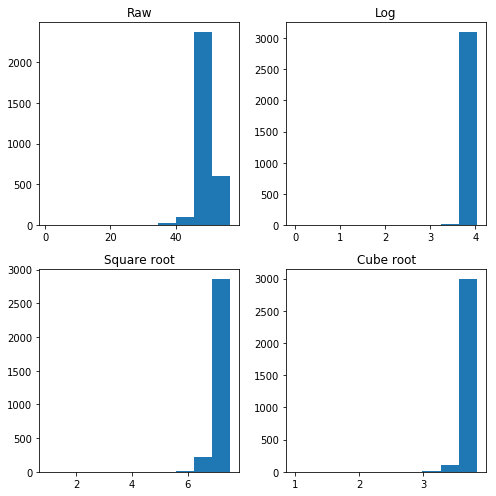

-------- four-panel Plot for white----------


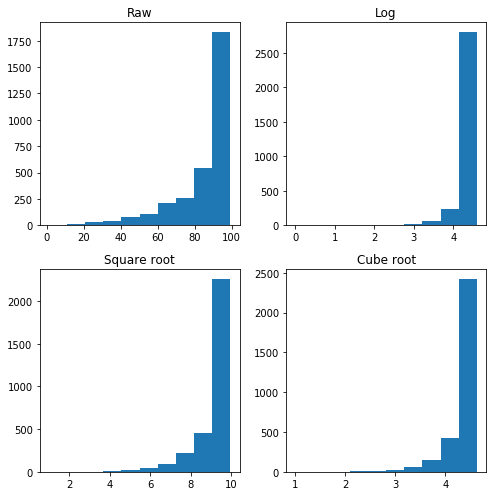

-------- four-panel Plot for black----------


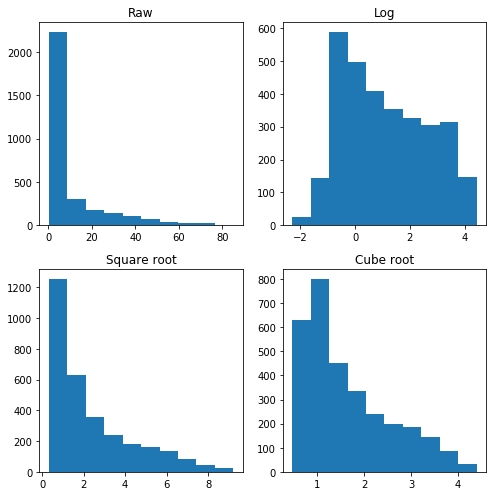

-------- four-panel Plot for asian----------


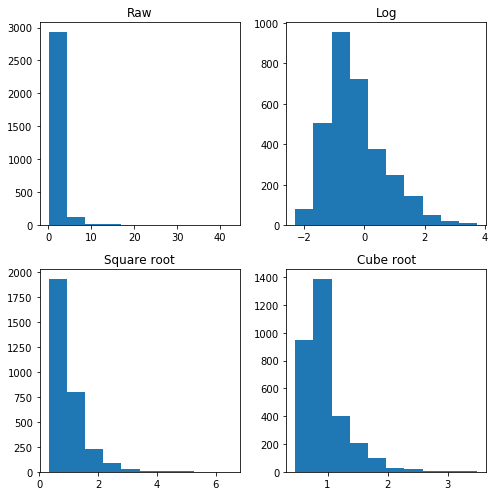

-------- four-panel Plot for pacific_islander----------


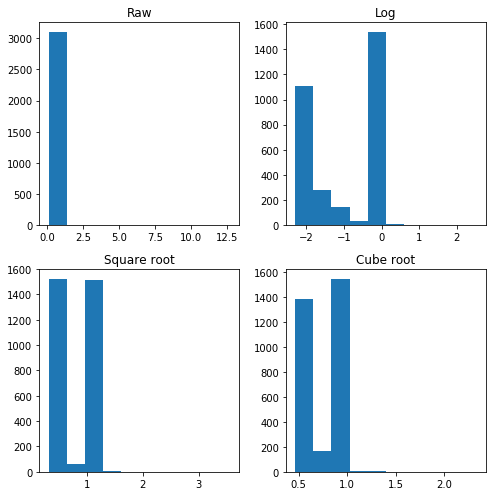

-------- four-panel Plot for two_plus_races----------


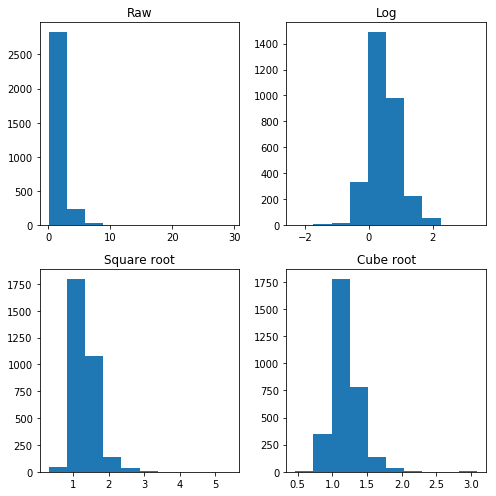

-------- four-panel Plot for hispanic----------


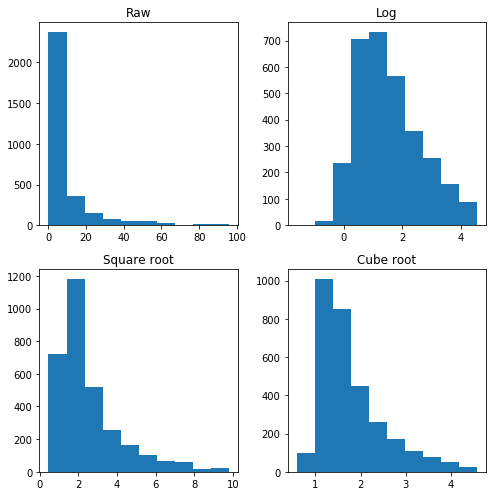

-------- four-panel Plot for white_alone_non_hisp----------


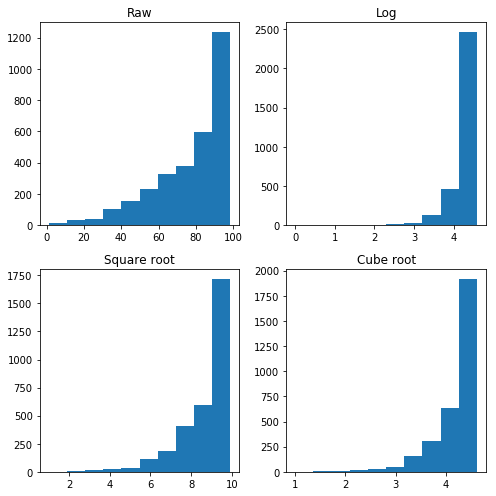

-------- four-panel Plot for same_home_one_year_plus----------


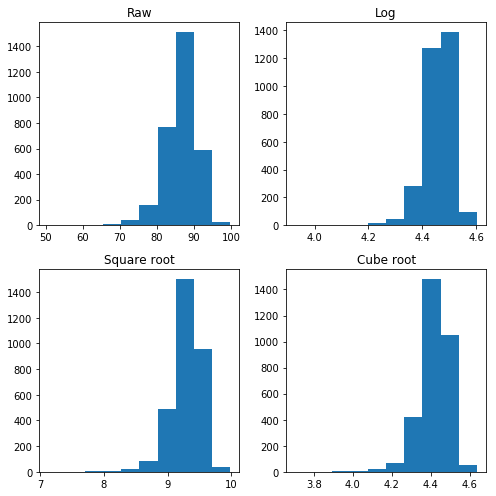

-------- four-panel Plot for foreign_born----------


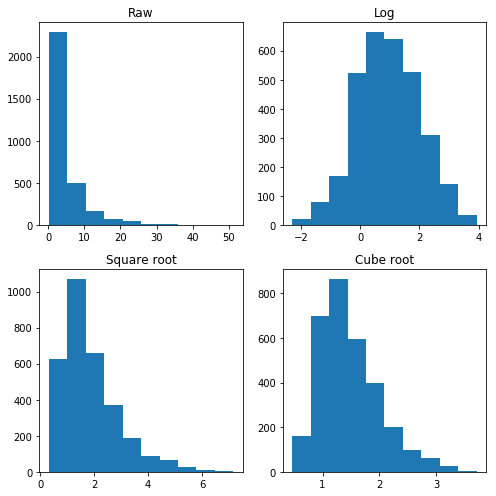

log 0.25867067939
-------- four-panel Plot for bilingual----------


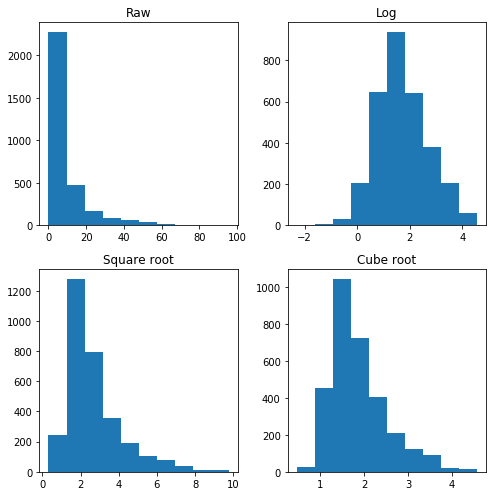

-------- four-panel Plot for hs_diploma_per----------


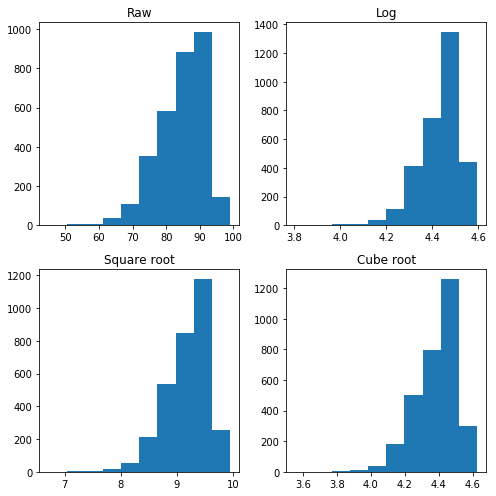

-------- four-panel Plot for bachelors_per----------


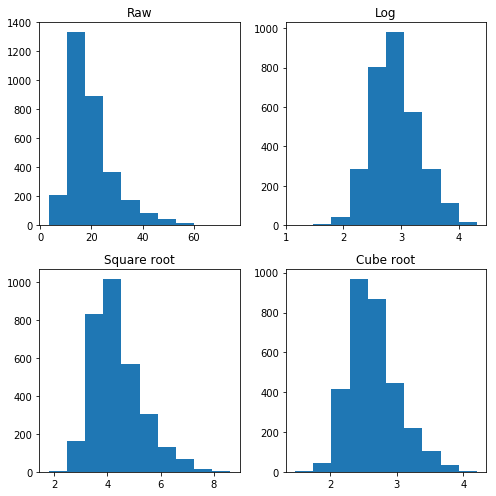

-------- four-panel Plot for veterans----------


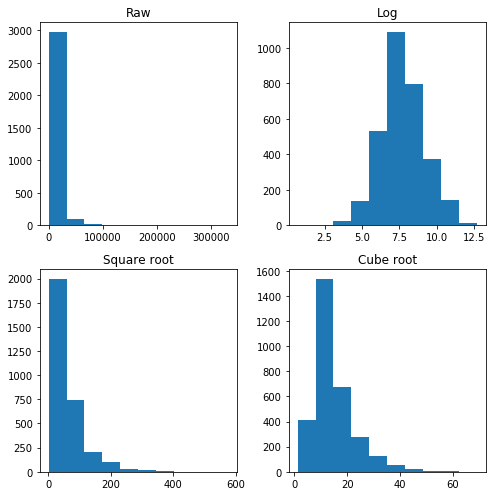

-------- four-panel Plot for housing_units----------


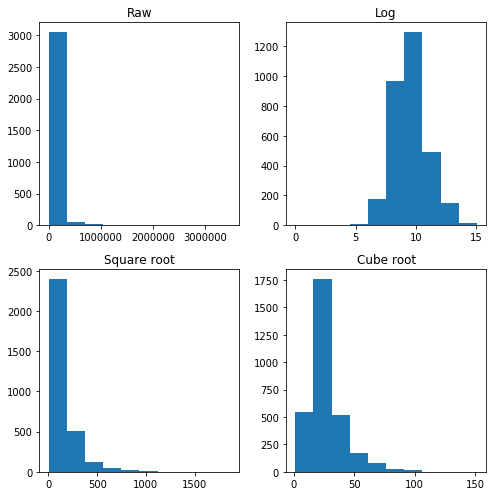

-------- four-panel Plot for home_ownership----------


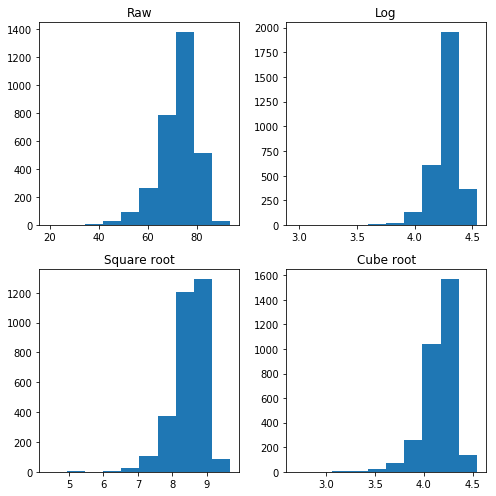

-------- four-panel Plot for multi_unit_housing----------


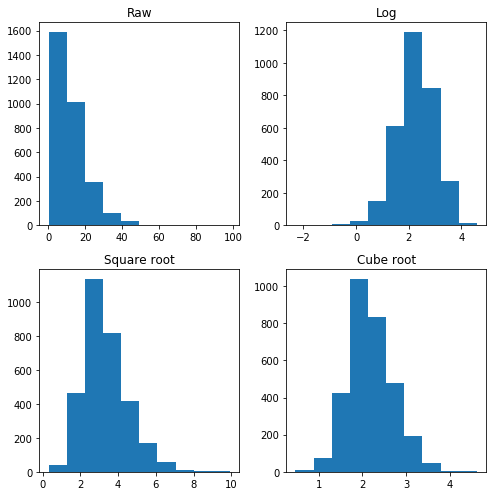

-------- four-panel Plot for median_home_value----------


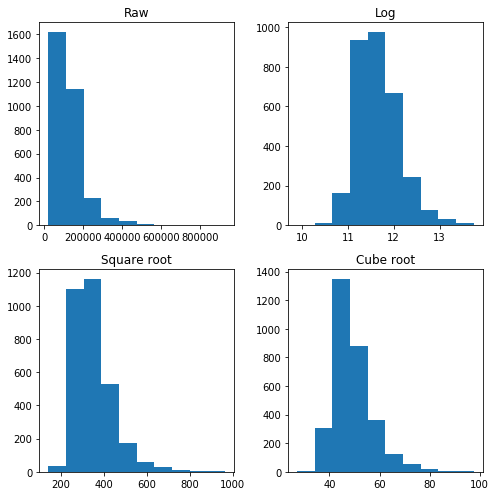

-------- four-panel Plot for households----------


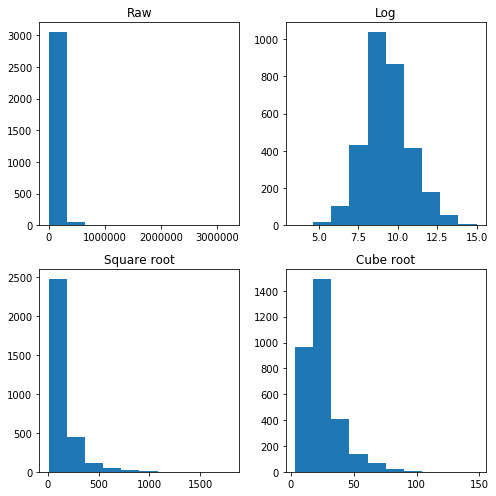

-------- four-panel Plot for per_capita_income----------


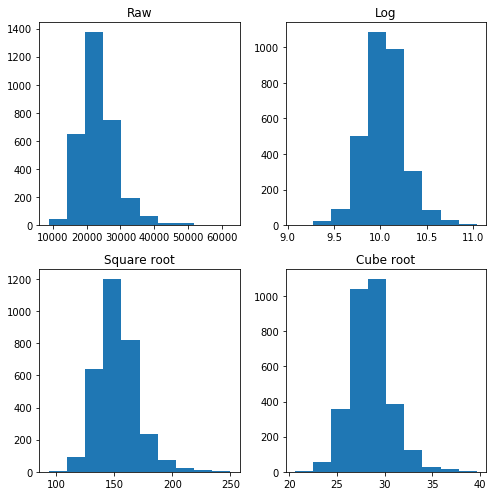

-------- four-panel Plot for median_income----------


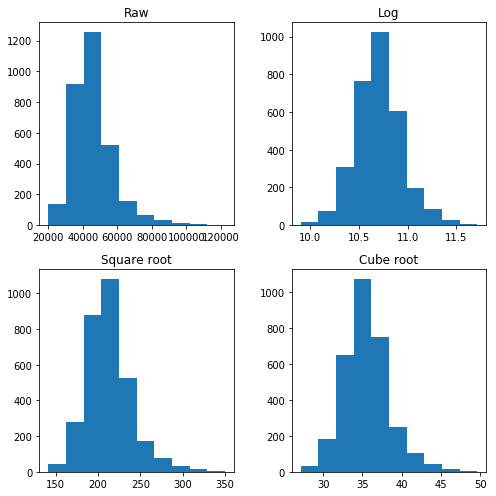

-------- four-panel Plot for poverty_per----------


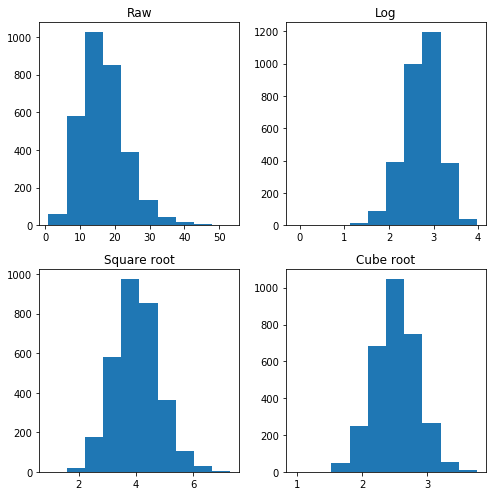

cube 0.0708145572321
-------- four-panel Plot for private_establishments----------


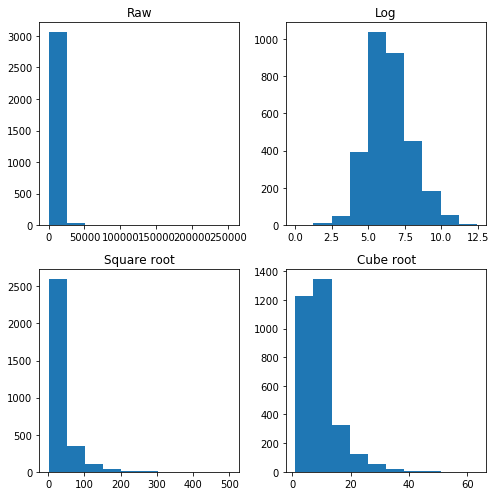

-------- four-panel Plot for private_nonfarm_employemnt----------


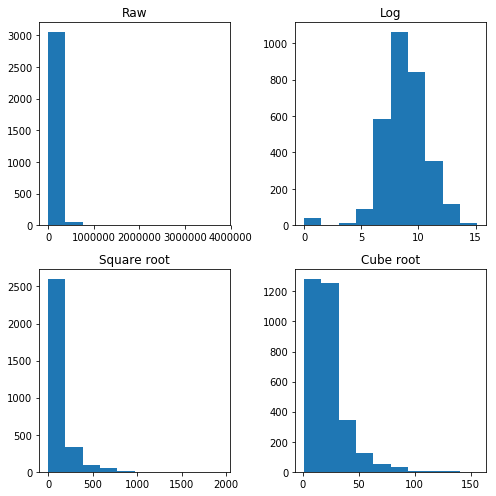

-------- four-panel Plot for non_employer_establishments----------


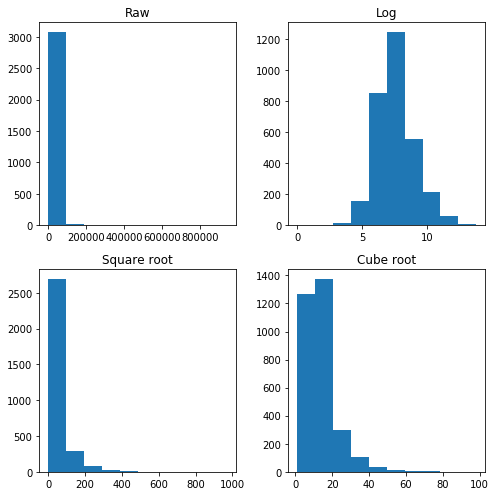

-------- four-panel Plot for total_firms----------


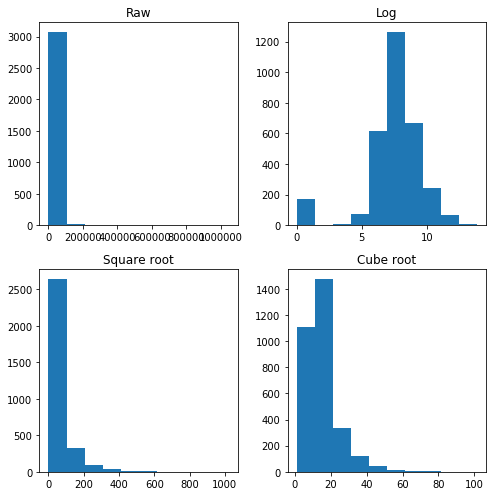

-------- four-panel Plot for black_firms----------


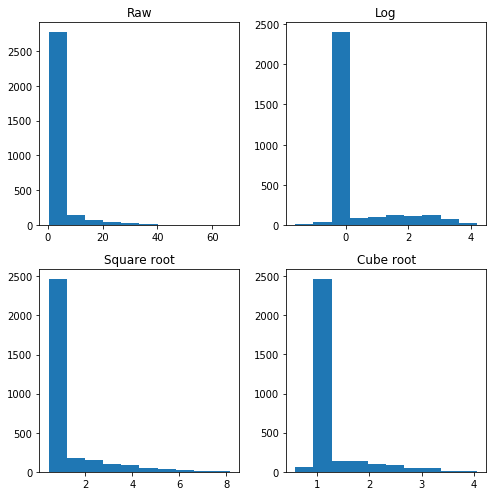

-------- four-panel Plot for american_indian_firms----------


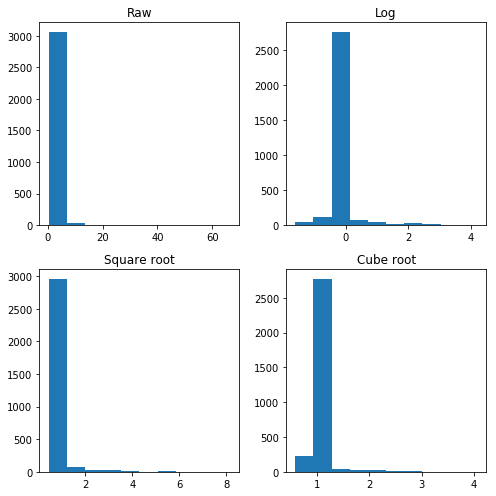

-------- four-panel Plot for asian_firms----------


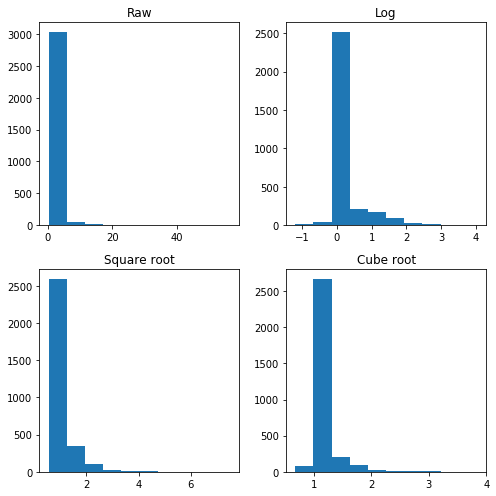

-------- four-panel Plot for pacific_islander_firms----------


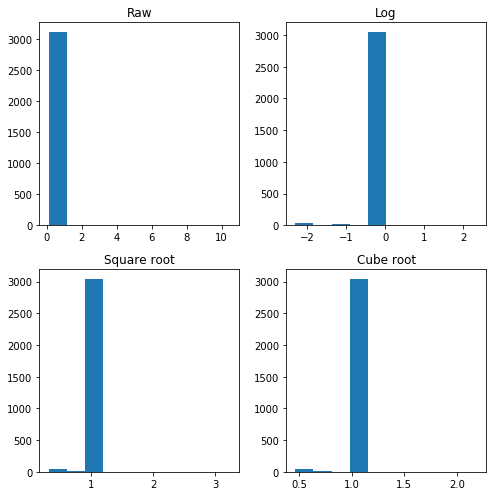

-------- four-panel Plot for hispanic_firms----------


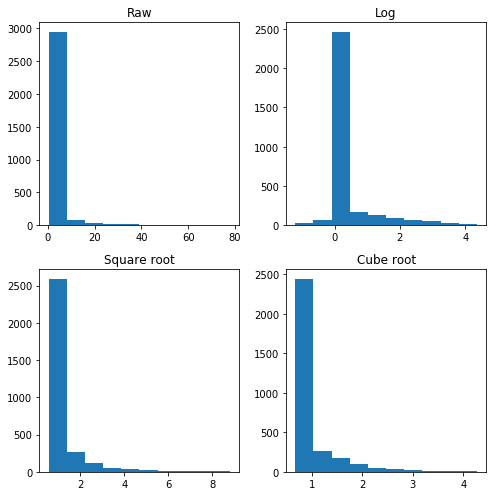

-------- four-panel Plot for female_firms----------


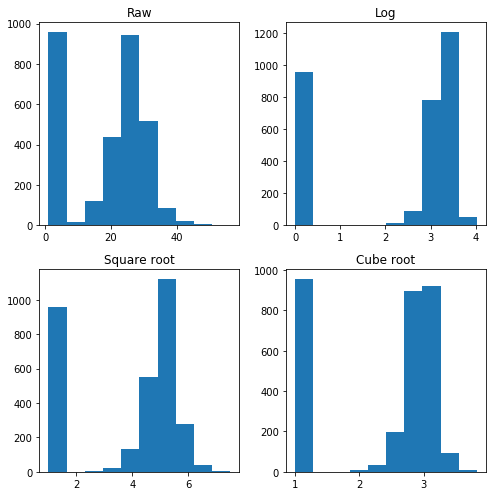

-------- four-panel Plot for manufacturing_shipments----------


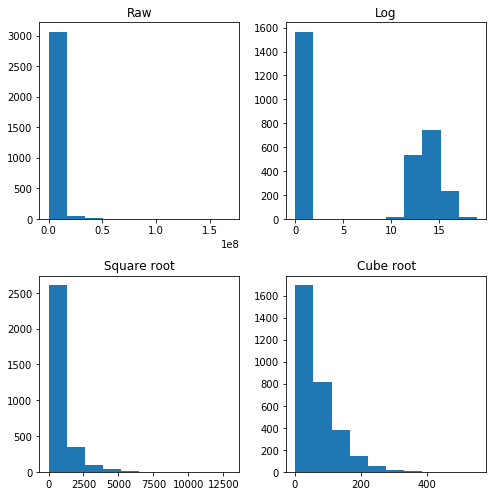

log 0.283779160545
-------- four-panel Plot for wholesaling_sales----------


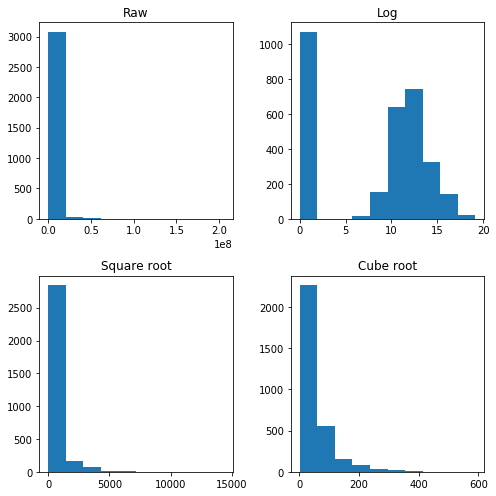

-------- four-panel Plot for retail_sales----------


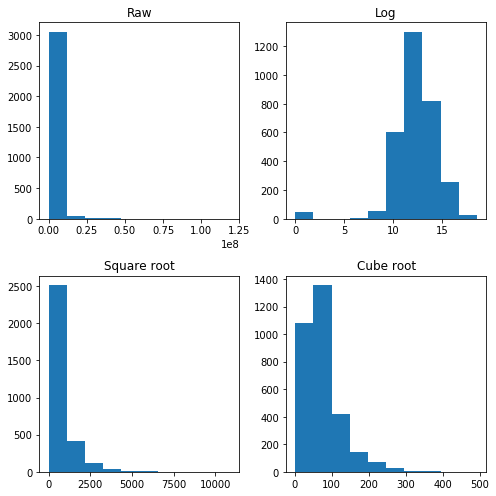

-------- four-panel Plot for retail_sales_per_cap----------


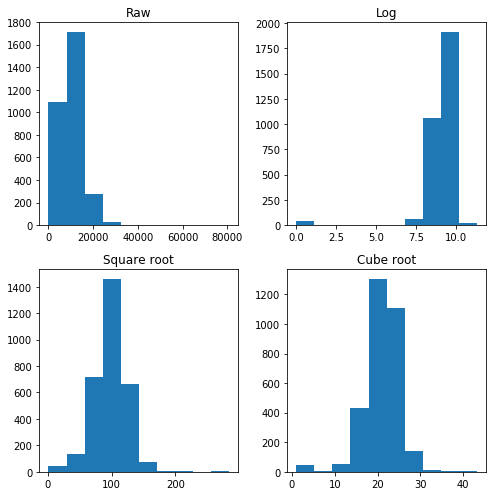

-------- four-panel Plot for hotel_food_sales----------


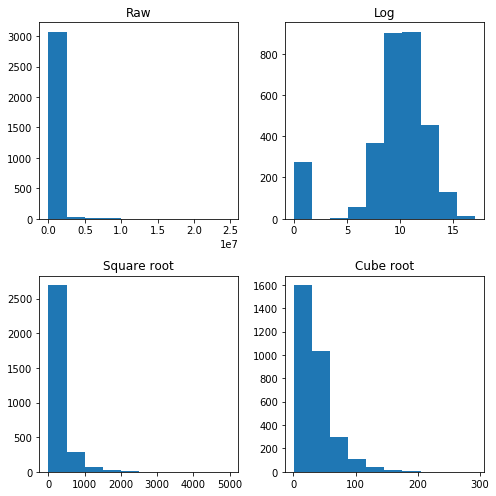

-------- four-panel Plot for building_permits----------


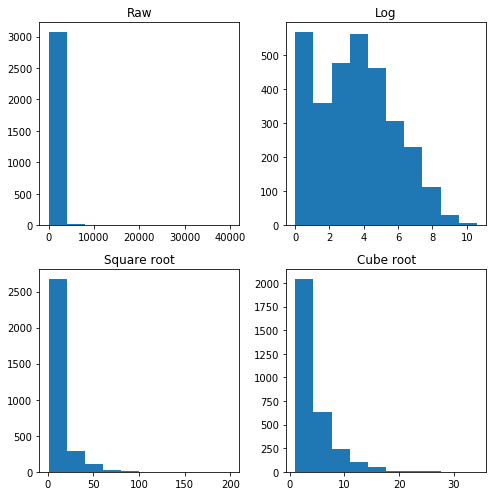

-------- four-panel Plot for pop_per_sm----------


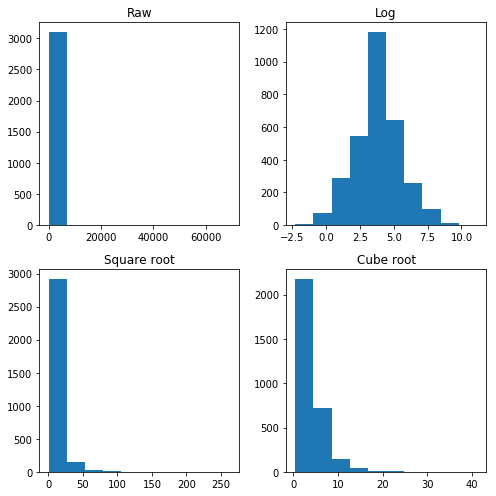

-------- four-panel Plot for margin_12----------


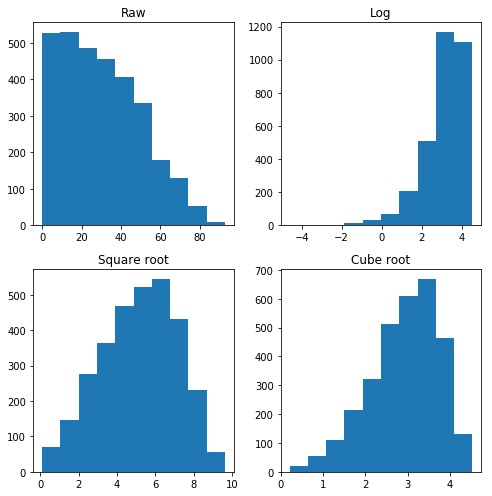

-------- four-panel Plot for turnout_12----------


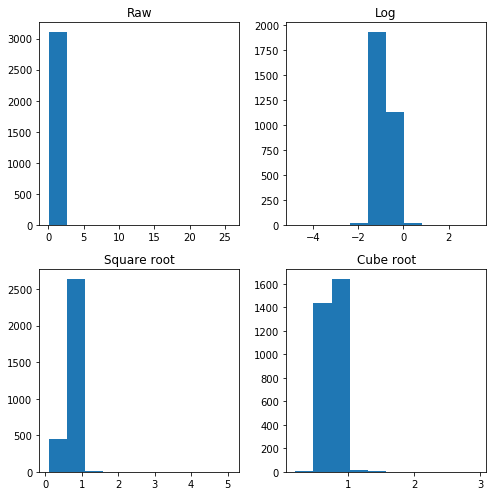

-------- four-panel Plot for turnout_08----------


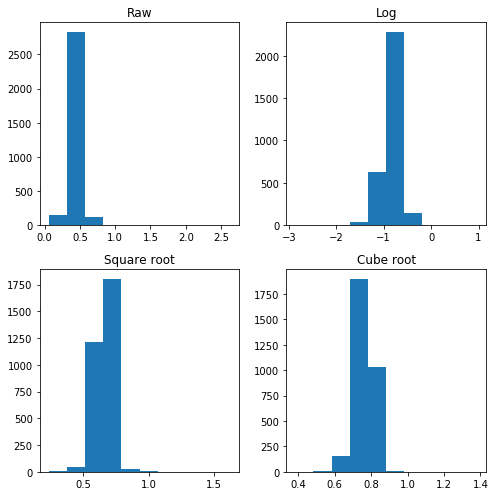

In [53]:
# Making a four-panel plot for each continuous variable
t = election_features.drop(['winner_04','margin_04','winner_08','margin_08','winner_12'], axis=1)
t[t == 0] = 1
for col in t.columns:
    print('-'*8,'four-panel Plot for {}----------'.format(col))
    plt.figure(figsize=(7,7))
    
    plt.subplot(221)
    plt.hist(t[col])
    plt.title('Raw')
    
    plt.subplot(222)
    plt.hist(np.log(t[col]))
    plt.title('Log')
    
    plt.subplot(223)
    plt.hist(np.sqrt(t[col]))
    plt.title('Square root')
    
    plt.subplot(224)
    plt.hist(t[col]**(1/3))
    plt.title('Cube root')
    plt.tight_layout()
    plt.show()
    
    
    _,val = stats.normaltest(np.sqrt(t[col])) 
    if val > .05:
        print ('sqrt',val)
    else:
        pass
    
    _,val = stats.normaltest(t[col]**(1/3)) 
    if val > .05:
        print ('cube', val)
    else:
        pass
    
    _,val = stats.normaltest(np.log(t[col])) 
    if val > .05:
        print ('log', val)
    else:
        pass
    


A few transformations pass the normal test and look interesting:

- log foreign born
- cube poverty per
- log manufacturing shipments

I'm going to leave the others alone and turn 2 of these into new features and make sure they are independant of my outcome

In [54]:
election_features= election_features.replace({'foreign_born': {0: 1},
                                             'manufacturing_shipments': {0: 1}})

election_features['log_foreign_born'] = np.log(election_full.foreign_born)
election_features['log_manufacturing_shipments'] = np.log(election_features.manufacturing_shipments)



new = ['log_foreign_born', 'log_manufacturing_shipments']


p_vals = pd.DataFrame(columns=['Feature', 'P_value'])
vals = pd.DataFrame(columns=['Feature', 'value'])
u_vals = pd.DataFrame(columns=['Feature', 'U_value'])

for col in new: #initialize loop 
    
   # plt.figure(figsize=(16,5))
    #plt.subplot(121)
    #sns.distplot(election_features[col], color = 'gray')
    
    #plt.subplot(122)
    #sns.boxplot(x="winner_12", y=col, data=election_features, palette = my_pal_binary, showfliers = False)
    
    #plt.tight_layout()
    #plt.show()
    
   
       
    _, p_val = ttest_ind(election_features[election_features['winner_12']==0][col],
                             election_features[election_features['winner_12']==1][col])
    if p_val >= .05:
        print(p_val)
    else:
        pass
    
    _,u_val = stats.mannwhitneyu(election_features[election_features['winner_12']==0][col],
                             election_features[election_features['winner_12']==1][col])
    if u_val >= .05:
           print(u_val)
    else:
        pass




In [55]:
election_features.drop(['foreign_born','manufacturing_shipments'], axis =1 , inplace = True)




There isn't a logical time efficient way to reduce these features, so I'm going to turn Recursive Feature Elimination to narrow down my features for me.

In [56]:
features = election_features.drop(['winner_12','log_foreign_born','margin_12','white'], axis =1)
outcome = election_features.winner_12

from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE
#instantiate and fit LR model
model = LogisticRegressionCV()
rfe = RFE(model, 10)
rfe = rfe.fit(features, outcome)


#assign rankings to column_num variable and print
column_num = rfe.ranking_
print(rfe.support_)
print(rfe.ranking_)
print(rfe.score(features,outcome))

[False False False  True False  True False  True False False False  True
 False False False False False False False  True False False False False
  True False False False False False False False False False False False
 False False False False False  True  True  True  True False False False]
[23 17 16  1 11  1  2  1 39 33  7  1 13  3 12 10 19 30  9  1 27 20 26 25  1
 29 31 21 24  8  6  4 38 15 14 35 34 28 32 18 22  1  1  1  1 37 36  5]
0.967855994857


In [57]:
#Turn the ranking above into a list and cut out features that aren't scored '1'

#assign cols to an empty list
cols = []
#create a for loop that enumerates indexes and values
for idx, val in enumerate(column_num):
    if val == 1:
        cols.append(idx)
        
#use cols list to create new array of the features I want to keep
X_slim=features.iloc[:, cols]
X_slim.columns

Index(['under_18', 'female', 'asian', 'white_alone_non_hisp',
       'multi_unit_housing', 'poverty_per', 'winner_04', 'margin_04',
       'winner_08', 'margin_08'],
      dtype='object')

Perfect. We kept our election features from the previous years and got a nice mix of demographic features that cover gender race and income. We don't need to check the correlations, but we'll take a look anyway just to understand the influences going into modeling.

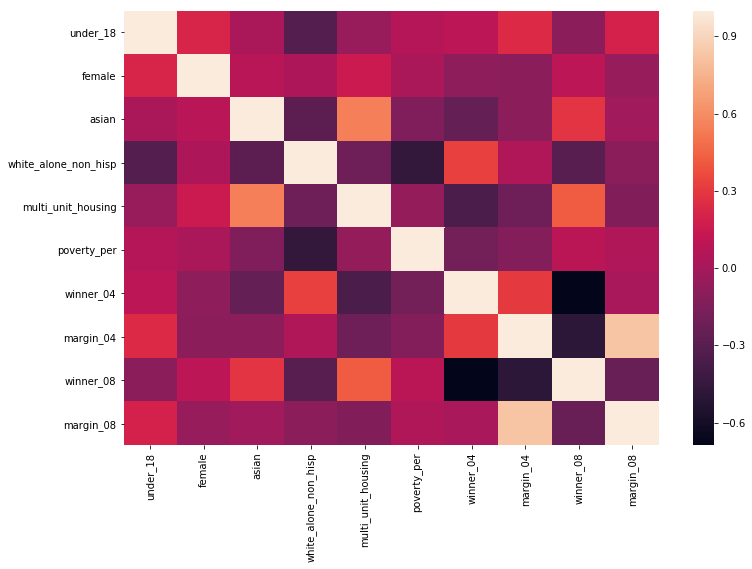

In [59]:

#initiate subplots and assign fig size
plt.subplots(figsize=(12,8))

#plot correlation matrix
sns.heatmap(X_slim.corr())
plt.show()


### Modeling

We have a large class imbalance, so we'll upsample using smote on the training data only using SMOTE. Then we'll train, tune, and test them on Logistic Regression, Random Forest, and Gradient Boosting models. We'll use the recall score on the true class, as well as interpertability considerations to select our final model.

In [60]:
from sklearn.model_selection import train_test_split
#set train size to 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_slim, outcome,
                                                    test_size =0.20,
                                                    random_state = 123)
from imblearn.over_sampling import SMOTE
# instantiate and fit SMOTE (upsampling)
sm = SMOTE(random_state =12, ratio = 1.0)
X_train_up, y_train_up = sm.fit_sample(X_train, y_train)

/Users/j/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


### Logistic Regression w/ upsampling

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#instantiate and fit LR model
lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)

#print results of model tested on train set
print(lr.score(X_train_up, y_train_up))
lr.get_params()

# Create dataframe to store coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(lr.coef_))], axis=1)
coefs_lg.columns = ['attribute', 'log_coef']
# Calculate coefficients 
coefs_lg['coef'] = np.exp(coefs_lg['log_coef'])

coefs_lg.sort_values('coef', ascending=False)

0.957430340557


,attribute,log_coef,coef
8,winner_08,4.313415,74.695109
1,female,0.250274,1.284377
9,margin_08,0.066938,1.069229
4,multi_unit_housing,0.059343,1.061139
2,asian,-0.065527,0.936574
5,poverty_per,-0.097357,0.907232
3,white_alone_non_hisp,-0.101360,0.903607
7,margin_04,-0.119875,0.887031
0,under_18,-0.195910,0.822086
6,winner_04,-2.392972,0.091358


2004 and 2012 looked like they might have had a lot in common. That's not the case. The 208 result is by far the most important feature. This might change things. 

In [ ]:
lr1 = LogisticRegression(penalty = 'l2', C = 2.78587674239, solver = 'liblinear')
lr1.fit(X_train_up, y_train_up)

#print results of model tested on train set
print(lr1.score(X_train_up, y_train_up))
lr1.get_params()

In [ ]:
#Create regularization penalty
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

#create solver hyperparameter
solver = ['liblinear', 'saga']

# Create hyperparameter options
hyperparameters = dict(C=C, solver = solver, penalty = penalty)

# Create randomized search 3-fold cross validation and 100 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=50, cv=3, n_jobs=-1, verbose=10)

# Fit randomized search
best_model = clf.fit(X_train_up, y_train_up)

# View best hyperparameters 
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
print('Best Score:', best_model.best_estimator_.get_params()['score'])

In [65]:
lr2 = LogisticRegression(penalty = 'l1', C = 3.71, solver = 'liblinear')
lr2.fit(X_train_up, y_train_up)

#print results of model tested on train set
print(lr2.score(X_train_up, y_train_up))
lr2.get_params()

# Printing Logistic Regression Intercept
print('log(Intercept):', lr2.intercept_)
print('Intercept:', np.exp(lr2.intercept_))

# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(lr2.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'log_Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Coef'] = np.exp(coefs_lg['log_Coef'])

coefs_lg.sort_values('Coef', ascending=False)

0.957430340557
log(Intercept): [ 0.]
Intercept: [ 1.]


,Attribute,log_Coef,Coef
8,winner_08,4.562603,95.832638
1,female,0.259772,1.296634
9,margin_08,0.066861,1.069147
4,multi_unit_housing,0.058027,1.059743
2,asian,-0.069806,0.932575
5,poverty_per,-0.099415,0.905367
3,white_alone_non_hisp,-0.105134,0.900204
7,margin_04,-0.117805,0.888869
0,under_18,-0.203932,0.815518
6,winner_04,-2.485283,0.083302


             precision    recall  f1-score   support

          0       0.96      0.95      0.96      1938
          1       0.95      0.96      0.96      1938

avg / total       0.96      0.96      0.96      3876



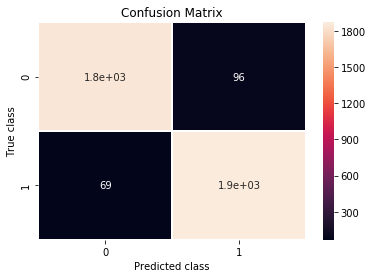

In [66]:
def conf(model,x,y):
    y_pred = model.predict(x)
    logreg_cm = confusion_matrix(y, y_pred)
    sns.heatmap(logreg_cm,
            annot=True,
            linewidths=0.5,)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title('Confusion Matrix')
    plt.savefig('Confusion Matrix')

    from sklearn.metrics import classification_report
    print(classification_report(y, model.predict(x)))
conf(lr2,X_train_up,y_train_up)


We get great accuracy and recall with this model. In this case, we might be overpredicting a democratic win because democratic counties typically have more people.

### Random Forest no upsampling

In [67]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
rf.get_params()

0.997990353698


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1938
          1       1.00      0.99      1.00       550

avg / total       1.00      1.00      1.00      2488



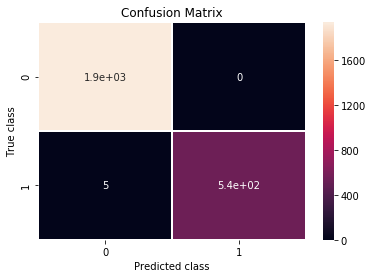

In [68]:
conf(rf,X_train, y_train)

In [75]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier() 

# Create hyperparamater values
max_features = np.arange(2,11,1)
max_depth = np.arange(1, 100, 5)
min_samples_leaf = np.arange(1, 10, 1)

# Create hyperparameter options
hyperparameters = dict(max_features = max_features,
                       max_depth = max_depth,
                       min_samples_leaf = min_samples_leaf)

# Create randomized search 2-fold cross validation and 50 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(rfc, hyperparameters, random_state=1, n_iter=100, cv=2, verbose=1)
# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print(clf.best_score_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best max_features: 8
Best max_depth: 16
Best min_samples_leaf: 5
0.968649517685


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.9s finished


In [76]:
for feature in zip(X_test.columns, rf.feature_importances_):
    print(feature)

('under_18', 0.029511616281449791)
('female', 0.020613549317292389)
('asian', 0.032252593195645038)
('white_alone_non_hisp', 0.11425101070334102)
('multi_unit_housing', 0.044899508552469547)
('poverty_per', 0.028859451728672769)
('winner_04', 0.16422214817013892)
('margin_04', 0.074908867817886429)
('winner_08', 0.37776703056064498)
('margin_08', 0.11271422367245906)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1938
          1       1.00      0.99      1.00       550

avg / total       1.00      1.00      1.00      2488



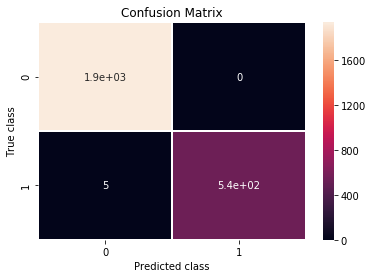

In [77]:
conf(rf,X_train,y_train)

As random forest usually does, it fits the model very well. Probably too well.

### Gradient Boosting w/ upsampling

In [78]:
# Gradient booster
gbc = GradientBoostingClassifier()
gbc.fit(X_train_up, y_train_up)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_gbc = cross_val_score(gbc, X_train_up, y_train_up, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_gbc.mean(), 
                                                                                    scores_gbc.std()*2))
gbc.get_params()


Cross Validation Accuracy Scores - Training Set: 0.976(+/- 0.02)


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [80]:
# Create hyperparamater values
max_features = np.arange(2,11,1)
max_depth = np.arange(1, 100, 5)
min_samples_leaf = np.arange(1, 10, 1)

# Create hyperparameter options
hyperparameters = dict(max_features = max_features,
                       max_depth = max_depth,
                       min_samples_leaf = min_samples_leaf)

# Create randomized search 2-fold cross validation and 50 iterations. Add verbosity for runtime
clf = RandomizedSearchCV(rfc, hyperparameters, random_state=1, n_iter=50, cv=2, verbose=1)
# Fit randomized search
best_model = clf.fit(X_train, y_train)

# View best hyperparameters 
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print(clf.best_score_)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best n_estimators: 10
Best max_depth: 51
Best min_samples_leaf: 9
0.968649517685


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished


             precision    recall  f1-score   support

          0       1.00      0.99      0.99      1938
          1       0.95      0.99      0.97       550

avg / total       0.99      0.99      0.99      2488



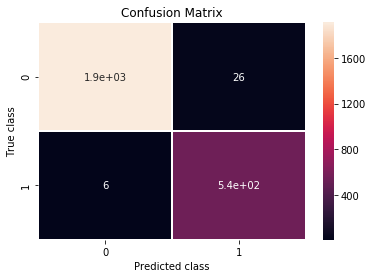

In [82]:
conf(gbc,X_train,y_train)

In [81]:
for feature in zip(X_test.columns, gbc.feature_importances_):
    print(feature)

('under_18', 0.059514353739247516)
('female', 0.043439806598351866)
('asian', 0.042007730101737764)
('white_alone_non_hisp', 0.12731600541491539)
('multi_unit_housing', 0.043518831105061932)
('poverty_per', 0.020377276257426854)
('winner_04', 0.090776432807330901)
('margin_04', 0.068435795244574354)
('winner_08', 0.25517656099018327)
('margin_08', 0.24943720774117031)


Gradient Boosting performs very well, and it isn't as overfit as the random forest model. Let's see how the models perform with testing.

### Testing

             precision    recall  f1-score   support

          0       0.99      0.95      0.97       482
          1       0.85      0.96      0.90       141

avg / total       0.96      0.95      0.95       623



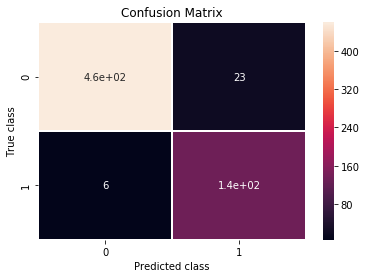

In [83]:
conf(lr2,X_test,y_test) #test logistic regression

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       482
          1       0.93      0.91      0.92       141

avg / total       0.96      0.96      0.96       623



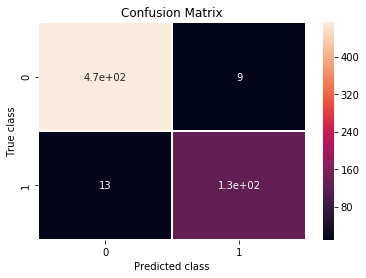

In [84]:
conf(rf,X_test, y_test) # test random forest

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       482
          1       0.89      0.95      0.92       141

avg / total       0.96      0.96      0.96       623



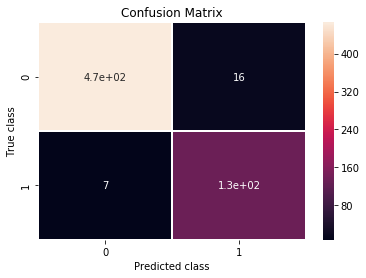

In [85]:
conf(gbc,X_test,y_test) # test gradient boosting

Gradient Boosting performed about as well as the random forest modell with logisitc regression coming in last. It's important to note though that my GBC model and RFC model are predicting different things even though the f1-score are about the same.

What I don't like about these models is that the previous years are too predictive. We'll try them below without election data.
- GBC predicts 16 counties to go Democrat that will go Republican. Those counties might be small and irrelevant, or it might include 5 large counties in Ohio that Democrats needed to win if they had any chance of winning the state.

### No Previous years data

In [169]:
from sklearn.model_selection import train_test_split
#set train size to 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X_slim.drop(['winner_08','winner_04','margin_04','margin_08','outcome'], axis=1), outcome,
                                                    test_size =0.20,
                                                    random_state = 123)

from imblearn.over_sampling import SMOTE
# instantiate and fit SMOTE (upsampling)
sm = SMOTE(random_state =12, ratio = 1.0)
X_train_up, y_train_up = sm.fit_sample(X_train, y_train)

/Users/j/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [170]:
lr = LogisticRegression()
lr.fit(X_train_up, y_train_up)

#print results of model tested on train set
print(lr.score(X_train_up, y_train_up))
lr.get_params()

# Create dataframe to store coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(lr.coef_))], axis=1)
coefs_lg.columns = ['attribute', 'log_coef']
# Calculate coefficients 
coefs_lg['coef'] = np.exp(coefs_lg['log_coef'])

coefs_lg.sort_values('coef', ascending=False)

0.791537667699


,attribute,log_coef,coef
1,female,0.175107,1.191374
4,multi_unit_housing,0.118935,1.126297
2,asian,0.002071,1.002073
5,poverty_per,-0.025927,0.974406
3,white_alone_non_hisp,-0.066433,0.935725
0,under_18,-0.236747,0.789191


             precision    recall  f1-score   support

          0       0.78      0.81      0.80      1938
          1       0.80      0.77      0.79      1938

avg / total       0.79      0.79      0.79      3876



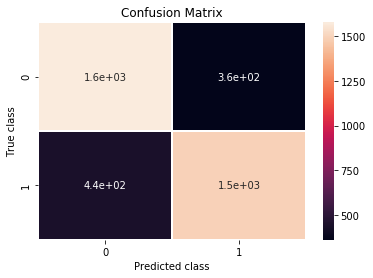

In [180]:
conf(lr,X_train_up,y_train_up)

In [172]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
rf.get_params()

0.990353697749


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1938
          1       1.00      0.96      0.98       550

avg / total       0.99      0.99      0.99      2488



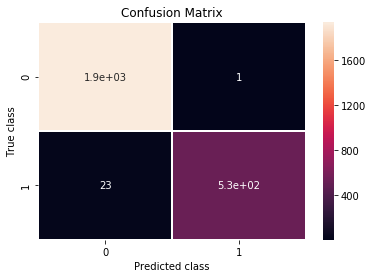

In [174]:
conf(rf,X_train,y_train)

In [176]:
# Gradient booster
gbc = GradientBoostingClassifier()
gbc.fit(X_train_up, y_train_up)

# Calculating and reporting scores from cross validation to +/- 2 standard deviations from the mean
scores_gbc = cross_val_score(gbc, X_train_up, y_train_up, cv=10)
print('Cross Validation Accuracy Scores - Training Set: {:.3f}(+/- {:.2f})'.format(scores_gbc.mean(), 
                                                                                    scores_gbc.std()*2))
gbc.get_params()


Cross Validation Accuracy Scores - Training Set: 0.855(+/- 0.05)


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

             precision    recall  f1-score   support

          0       0.95      0.89      0.92      1938
          1       0.68      0.84      0.75       550

avg / total       0.89      0.88      0.88      2488



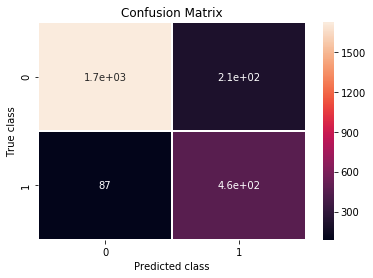

In [178]:
conf(gbc,X_train_up,y_train_up)

Logistic Regression does rather well with 80% precision and 77% recall. Random forest is the most accurate again and Gradient boosting performs the worst.

             precision    recall  f1-score   support

          0       0.91      0.82      0.86       482
          1       0.54      0.72      0.62       141

avg / total       0.83      0.80      0.81       623



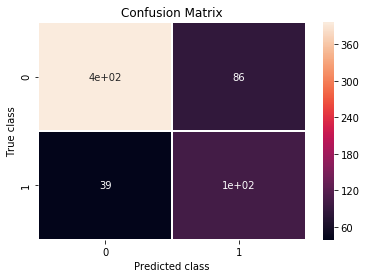

In [187]:
conf(lr,X_test,y_test)

             precision    recall  f1-score   support

          0       0.87      0.97      0.92       482
          1       0.83      0.50      0.63       141

avg / total       0.86      0.86      0.85       623



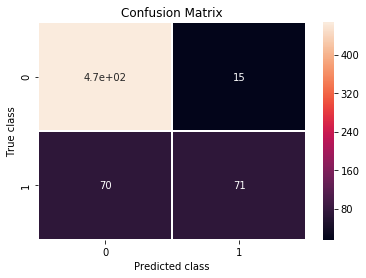

In [185]:
conf(rf,X_test,y_test)

In [175]:
for feature in zip(X_test.columns, rf.feature_importances_):
    print(feature)

('under_18', 0.12268215223130954)
('female', 0.10634878699566075)
('asian', 0.13841920418909517)
('white_alone_non_hisp', 0.26452328399482411)
('multi_unit_housing', 0.23587727803769173)
('poverty_per', 0.13214929455141874)


             precision    recall  f1-score   support

          0       0.91      0.87      0.89       482
          1       0.61      0.70      0.66       141

avg / total       0.84      0.83      0.84       623



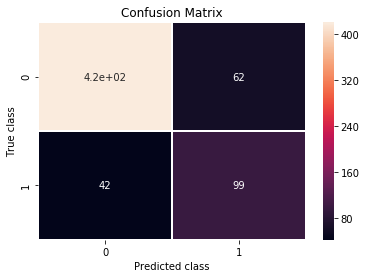

In [186]:
conf(gbc,X_test,y_test)

In [179]:
for feature in zip(X_test.columns, gbc.feature_importances_):
    print(feature)

('under_18', 0.17826465664697136)
('female', 0.13058582305192257)
('asian', 0.14807673173122957)
('white_alone_non_hisp', 0.25447340995142481)
('multi_unit_housing', 0.16633150126060836)
('poverty_per', 0.12226787735784328)


Ignore cells below

In [191]:
#after fitting the model use this to get the feature importance
feature_importance = gbc.feature_importances_

# sort the importances and get the indices of the sorting
sorted_idx = np.argsort(feature_importance)

#match the indices with the labels of the x matrix
#important: x must have columns names to do this
X_test.columns[feature_names[sorted_idx]]


NameError: name 'feature_names' is not defined

In [190]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence


my_plots = plot_partial_dependence(gbc,       
                                   features=[], # column numbers of plots we want to show
                                   X=X_test,            # raw predictors data.
                                   feature_names=([
'under_18',
'female', 
'asian', 
'white_alone_non_hisp', 
'poverty_per']),
# labels on graphs
                                  ) # number of values to plot on x axis



ZeroDivisionError: float division by zero

In [ ]:
['prediction'] = rf.predict(X_slim)

In [ ]:
#df_new  = df[df.outcome != df.prediction]
#df_new=df_new.loc[:, df.columns.isin(['diff_2016', 'state', 'county', 'outcome', 'prediction'])]

In [158]:
X_test['prediction'] = gbc.predict(X_test.drop(['outcome','prediction'], axis =1))
X_test['outcome'] = y_test


intermed = X_test[X_test.outcome != X_test.prediction]
targets = intermed[['outcome', 'prediction']]

#df = pd.merge(election_full,targets, left_index=True, right_index=True)


In [160]:
df = pd.merge(election_full,targets, left_index=True, right_index=True)
df.head()

,fips,county,state,population_2014,population_2010_estimated,pop_per_change,population_2010,under_5,under_18,over_65,female,white,black,american_indian,asian,pacific_islander,two_plus_races,hispanic,white_alone_non_hisp,same_home_one_year_plus,foreign_born,bilingual,hs_diploma_per,bachelors_per,veterans,commute_time,housing_units,home_ownership,multi_unit_housing,median_home_value,households,person_per_household,per_capita_income,median_income,poverty_per,private_establishments,private_nonfarm_employemnt,non_farm_employment_change,non_employer_establishments,total_firms,black_firms,american_indian_firms,asian_firms,pacific_islander_firms,hispanic_firms,female_firms,manufacturing_shipments,wholesaling_sales,retail_sales,retail_sales_per_cap,hotel_food_sales,building_permits,land_area_sqmiles,pop_per_sm,vote_rep_04,vote_dem_04,vote_oth_04,total_votes_04,pct_rep_04,pct_dem_04,pct_oth_04,winner_04,runnerup_04,pct_winner_04,margin_04,vote_rep_08,vote_dem_08,vote_oth_08,total_votes_08,pct_rep_08,pct_dem_08,pct_oth_08,winner_08,runnerup_08,pct_winner_08,margin_08,vote_rep_12,vote_dem_12,vote_oth_12,total_votes_12,pct_rep_12,pct_dem_12,pct_oth_12,winner_12,runnerup_12,pct_winner_12,margin_12,turnout_12,turnout_08,turnout_04,outcome,prediction
383,13053,Chattahoochee County,GA,11837,11267,5.1,11267,9.5,22.6,4.1,32.7,72.2,19.3,1.3,2.8,0.8,3.6,15.0,60.0,50.8,5.6,13.9,92.5,27.5,581,14.2,3343,28.8,28.1,97100,2613,3.54,20042,48758,11.9,97,1690,-5.0,251,341,36.4,0.0,0.0,0.0,0.0,29.3,0,0,12987,934,804,3,248.74,45.3,905,773,11,1689,53.6,45.8,0.7,rep,dem,53.6,7.8,811,830,1,1642,49.40,50.60,0.10,dem,rep,50.60,1.20,735.0,729.0,26.0,1490.0,49.33,48.93,1.74,rep,dem,49.33,0.40,0.132245,0.145735,0.149907,0,1
571,17011,Bureau County,IL,33840,34978,-3.3,34978,5.0,21.8,19.9,51.0,96.6,0.9,0.4,0.9,0.0,1.1,8.6,88.7,90.3,3.6,7.5,89.2,17.4,2803,20.4,15651,75.7,12.1,101200,13998,2.44,26705,48977,11.6,768,9484,-2.7,1982,2918,0.0,0.0,0.0,0.0,0.0,28.7,0,977575,331951,9525,27440,15,869.03,40.2,9822,7961,119,17902,54.9,44.5,0.7,rep,dem,54.9,10.4,7911,8889,313,17113,46.23,51.94,1.83,dem,rep,51.94,5.71,8164.0,8134.0,333.0,16631.0,49.09,48.91,2.00,rep,dem,49.09,0.18,0.475470,0.489250,0.511807,0,1
615,17099,LaSalle County,IL,111241,113922,-2.4,113924,5.4,22.1,17.6,49.8,95.2,2.3,0.3,0.9,0.0,1.2,8.9,86.9,88.6,3.3,6.4,88.4,15.9,9116,22.9,49869,75.8,13.5,125200,44257,2.50,25709,52640,12.2,2715,37250,-5.1,5827,8452,0.0,0.0,3.3,0.0,0.0,27.1,2244000,1208180,1739926,15466,158601,147,1135.12,100.4,26101,24263,365,50729,51.5,47.8,0.7,rep,dem,51.5,3.7,21872,27443,870,50185,43.58,54.68,1.73,dem,rep,54.68,11.10,23256.0,23073.0,930.0,47259.0,49.21,48.82,1.97,rep,dem,49.21,0.39,0.414829,0.440513,0.445288,0,1
817,19115,Louisa County,IA,11161,11387,-2.0,11387,5.3,23.2,16.6,49.3,95.1,1.0,0.5,2.1,0.2,1.2,16.2,79.8,90.3,8.1,15.0,83.3,13.5,815,23.0,5006,78.6,7.3,95400,4381,2.56,24272,50583,12.2,217,2887,1.3,621,941,0.0,0.0,0.0,0.0,0.0,0.0,0,0,56465,4798,4530,9,401.77,28.3,2572,2297,47,4916,52.3,46.7,1.0,rep,dem,52.3,5.6,2314,2523,83,4920,47.03,51.28,1.69,dem,rep,51.28,4.25,2420.0,2452.0,96.0,4968.0,48.71,49.36,1.93,dem,rep,49.36,0.65,0.436287,0.432072,0.431720,1,0
1066,21205,Rowan County,KY,23655,23333,1.4,23333,5.6,19.3,13.4,51.3,96.0,1.9,0.2,0.8,0.0,1.2,1.5,94.6,79.5,1.0,2.1,77.1,23.8,1231,21.0,10126,65.2,11.9,96700,8305,2.49,17094,35236,28.6,489,7148,-4.4,1405,1823,0.0,0.0,0.0,0.0,0.0,18.0,259812,54111,272076,12039,36058,14,279.80,83.4,4063,4556,87,8706,46.7,52.3,1.0,dem,rep,52.3,5.6,3907,4074,173,8154,47.92,49.96,2.12,dem,rep,49.96,2.04,4035.0,3438.0,168.0,7641.0,52.81,44.99,2.20,rep,dem,52.81,7.82,0.327476,0.349462,0.373120,0,1


In [109]:
df_new  = df[df.outcome != df.prediction]
df_new=df_new.loc[:, df.columns.isin(['diff_2016', 'state', 'county', 'outcome', 'prediction'])]
df.join(df2, how='outer')

AttributeError: 'DataFrame' object has no attribute 'outcome'

In [86]:
df['prediction'] = rf.predict(X_slim)
df_new  = [df.outcome != df.prediction]

NameError: name 'df' is not defined